In [1]:
import lucem_illud #Special module written for this class

import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm #Still for graphics
import matplotlib.colors # For nice colours
import wordcloud
import numpy as np
import scipy
import glob
import seaborn as sns
import sklearn.manifold
import itertools
import json
import ast
import urllib.parse
from bs4 import BeautifulSoup as bs
import spacy #comp-linguistics
import graphviz #displays the graphs
import gensim#For topic modeling

#These are from the standard library
import os.path
import zipfile
import subprocess
import io
import tempfile

#To process text data
import re
import time
import string
import statsmodels.formula.api as smf
from gensim import corpora, models
from collections import Counter
from datetime import datetime
from langdetect import detect
from textblob import Word
import nltk
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

/Users/gaomingtao/opt/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


## Load Dataset

In [2]:
# Load Dataset
brand = "Lululemon"
reddit = pd.read_csv("Data/Reddit/{}.csv".format(brand))
twitter = pd.read_csv("Data/Twitter/{}.csv".format(brand))
ins = pd.read_csv("Data/Instagram/{}.csv".format(brand))
youtube = pd.read_csv("Data/YouTube/{}.csv".format(brand))

In [3]:
#Combine the title and body of Reddit posts
reddit['body'].replace(np.nan, "", inplace=True)
reddit['text'] = reddit['title'] + reddit['body']
twitter['text'] = twitter['text'].str.replace('http\S+|www.\S+', '', case=False)
ins.rename(columns={'caption': 'text'}, inplace=True)
youtube['text'] = youtube['title'] + youtube['captions']

In [4]:
#Drop nan and duplicate text
def drop_na_dup(df):
    if 'Unnamed: 0' in df.columns:
        df.drop(columns=['Unnamed: 0'], inplace=True)
    df.drop_duplicates(inplace=True)
    df.dropna(subset = ["text"], inplace=True)
    
drop_na_dup(reddit)
drop_na_dup(twitter)
drop_na_dup(ins)
drop_na_dup(youtube)

In [5]:
pd.DataFrame({'data': ['Reddit', 'Twitter', 'Instagram', 'YouTube'],
              'shape': [reddit.shape, twitter.shape, ins.shape, youtube.shape,]})

,data,shape
0,Reddit,"(2667, 8)"
1,Twitter,"(5293, 9)"
2,Instagram,"(2803, 10)"
3,YouTube,"(521, 13)"


## Counting Words & Phrases

#### Tokenize

In [6]:
def tokenize(df, size=2400):
    df = df[:size]
    df['tokenized_text'] = df['text'].apply(lambda x: lucem_illud.word_tokenize(x))
    df['word_counts'] = df['tokenized_text'].apply(lambda x: len(x))
    return df
    
reddit = tokenize(reddit)
twitter = tokenize(twitter)
ins = tokenize(ins)
youtube = tokenize(youtube)

#### Words Count

In [7]:
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))

def wordCounter(df, limit=20):
    tokens = []
    for token in df['tokenized_text']:
        tokens += token

    wordCounts = {}
    for word in df['tokenized_text'].sum():
        wLower = word.lower()
        if word not in stopwords:
            if word in wordCounts:
                wordCounts[word] += 1
            else:
                wordCounts[word] = 1
    
    wordFreq_lst = []
    for word, count in sorted(wordCounts.items(), key = lambda x : x[1], reverse = True)[:limit]:
        wordFreq_lst.append(word)
    
    wordCounts_df = {'word' : [], 'count' : []}
    for w, c in wordCounts.items():
        wordCounts_df['word'].append(w)
        wordCounts_df['count'].append(c)
    wordCounts_df = pd.DataFrame(wordCounts_df) 
    wordCounts_df.sort_values('count', ascending=False, inplace=True)
    return tokens, wordFreq_lst, wordCounts_df

In [8]:
token_rdt, wordFreq_rdt, wordsCount_rdt = wordCounter(reddit)
token_twt, wordFreq_twt, wordsCount_twt = wordCounter(twitter)
token_ins, wordFreq_ins, wordsCount_ins = wordCounter(ins)
token_ytb, wordFreq_ytb, wordsCount_ytb = wordCounter(youtube)

In [9]:
def normalize(df, words_freq, limit=5):
    df['normalized_tokens'] = df['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x, extra_stop=words_freq[:limit]))
    return df

reddit = normalize(reddit, wordFreq_rdt)
twitter = normalize(twitter, ['rt'] + wordFreq_twt, 8)
ins = normalize(ins, wordFreq_ins)
youtube = normalize(youtube, wordFreq_ytb, 10)

In [10]:
def detectLanguage(df, col):
    for index, row in df[col].iteritems():
        try:
            lang = detect(row)
            df.loc[index, 'language'] = lang
        except:
            df.loc[index, 'language'] = "not detectable"
    return df

In [11]:
reddit = detectLanguage(reddit,'text')
reddit = reddit[reddit['language'] == 'en']
twitter = detectLanguage(twitter,'text')
twitter = twitter[twitter['language'] == 'en']
ins = detectLanguage(ins,'text')
ins = ins[ins['language'] == 'en']

In [12]:
reddit.head()

,body,created,num_commns,title,upvote_ratio,upvotes,url,text,tokenized_text,word_counts,normalized_tokens,language
0,Just curious because I've been buying LLL 'reg...,2021-03-09 16:03:56,0,When you buy LLL leggings that are a little to...,1.0,1,https://www.reddit.com/r/lululemon/comments/m1...,When you buy LLL leggings that are a little to...,"[When, you, buy, LLL, leggings, that, are, a, ...",60,"[buy, lll, leggings, little, long, curious, ve...",en
1,Which one do you prefer and why? Tia.\n\n[View...,2021-03-09 15:57:37,0,Which joggers? Sell me in the comments! Scuba ...,1.0,1,https://www.reddit.com/r/lululemon/comments/m1...,Which joggers? Sell me in the comments! Scuba ...,"[Which, joggers, Sell, me, in, the, comments, ...",23,"[joggers, sell, comments, scuba, vrs, ready, r...",en
2,Hi there - I have a relatively large head (\~2...,2021-03-09 15:57:31,0,Men - On The Fly Ball Cap vs Days Shade Ball Cap,1.0,1,https://www.reddit.com/r/lululemon/comments/m1...,Men - On The Fly Ball Cap vs Days Shade Ball C...,"[Men, On, The, Fly, Ball, Cap, vs, Days, Shade...",52,"[men, fly, ball, cap, vs, days, shade, ball, c...",en
3,,2021-03-09 15:45:00,5,Workout fit 💅🏼,0.8,6,https://www.reddit.com/gallery/m1fu41,Workout fit 💅🏼,"[Workout, fit, 💅, 🏼]",4,"[workout, fit, 💅, 🏼]",en
4,Been eyeing that WU since it came out...... an...,2021-03-09 15:44:24,2,Anyone else like me patiently waiting for Marb...,1.0,2,https://www.reddit.com/r/lululemon/comments/m1...,Anyone else like me patiently waiting for Marb...,"[Anyone, else, like, me, patiently, waiting, f...",53,"[like, patiently, waiting, marbel, dye, wu, lu...",en


In [13]:
twitter.head()

,time,text,user_name,user_location,retweet_cnt,favorite_cnt,hashtags,user_mentions,is_retweet,tokenized_text,word_counts,normalized_tokens,language
0,2021-03-09 19:14:53,Check out this listing I just added to my #Pos...,JJbunni88,NaN,0,0,['Poshmark'],[],False,"[Check, out, this, listing, I, just, added, to...",20,"[check, listing, added, poshmark, closet, wund...",en
2,2021-03-09 19:07:47,Check out this listing I just added to my #Pos...,alexandra__cari,"Fort Lauderdale, FL",0,0,['Poshmark'],[],False,"[Check, out, this, listing, I, just, added, to...",16,"[check, listing, added, poshmark, closet, alig...",en
3,2021-03-09 19:01:51,@jackiepearl66 @calvinmcdonald @FastCompany @l...,getthemirror,United States,0,0,[],"['jackiepearl66', 'calvinmcdonald', 'FastCompa...",False,"[@jackiepearl66, @calvinmcdonald, @FastCompany...",16,"[@jackiepearl66, @calvinmcdonald, @fastcompany...",en
4,2021-03-09 19:00:49,Check out this listing I just added to my #Pos...,JJbunni88,NaN,0,0,"['Poshmark', 'shopmycloset']",['Poshmarkapp'],False,"[Check, out, this, listing, I, just, added, to...",19,"[check, listing, added, poshmark, closet, 🍋, e...",en
5,2021-03-09 18:57:52,Awesome work @MARC_NeilO ! Glad you love your ...,MARC_KristinaY,Newmarket,0,0,"['WhereWeWork', 'TurtleToteBag', 'theMARCgroup...","['MARC_NeilO', 'lululemon']",False,"[Awesome, work, @MARC_NeilO, Glad, you, love, ...",13,"[awesome, work, @marc_neilo, glad, love, custo...",en


In [14]:
ins.head()

,text,country,dimensions,full_name,image_url,likes,location,tagged_account,timestamp,user,tokenized_text,word_counts,normalized_tokens,language
0,Flashback to 2018 when I got to make this gian...,NaN,"{'height': 1350, 'width': 1080}",Learn To Weave | Jenell Flynn,https://instagram.ffxe1-1.fna.fbcdn.net/v/t51....,1221,NaN,[],2021-03-09 01:41:01,spruceandlinen,"[Flashback, to, 2018, when, I, got, to, make, ...",144,"[flashback, got, giant, custom, weaving, store...",en
1,This was me after waiting for my clothes to dr...,US,"{'height': 1248, 'width': 1080}",Joy Sun,https://instagram.ffxe1-1.fna.fbcdn.net/v/t51....,1450,"{'street_address': '', 'zip_code': '96792', 'c...","['lululemon', 'laneeight', 'welaapparel']",2021-03-07 14:51:25,liftwithjoy,"[This, was, me, after, waiting, for, my, cloth...",47,"[waiting, clothes, dry, cause, playing, catch,...",en
2,"here’s to all the women of strength, both ment...",NaN,"{'height': 800, 'width': 640}",Katrina Brewer,https://instagram.ffxe1-1.fna.fbcdn.net/v/t51....,122,NaN,"['gymshark', 'lululemon', 'jorgeq']",2021-03-08 18:05:49,trinabeans28,"[here, ’s, to, all, the, women, of, strength, ...",31,"[women, strength, mental, physical, inspire, e...",en
3,happy Monday from me & all the kale stuck in m...,NaN,"{'height': 1350, 'width': 1080}",BRE SHEPPARD,https://instagram.ffxe1-1.fna.fbcdn.net/v/t51....,29781,NaN,"['freepeople', 'liketoknow.it', 'lululemon', '...",2021-03-08 22:21:58,bresheppard,"[happy, Monday, from, me, all, the, kale, stuc...",33,"[happy, monday, kale, stuck, teeth, drinking, ...",en
4,s o e x c i t e d 🎉\n\nto welcome our @navina...,CA,"{'height': 617, 'width': 1080}",Sarah Dawne 🌻,https://instagram.ffxe1-1.fna.fbcdn.net/v/t51....,186,"{'street_address': '#211, 316 Windermere Road ...","['lululemon', 'yegfitness', 'navina_yoga', 'ye...",2021-03-09 09:42:54,sarahdawneyoga,"[s, o, e, x, c, i, t, e, d, 🎉, to, welcome, ou...",130,"[s, o, e, x, c, t, e, d, 🎉, welcome, @navina_y...",en


In [15]:
youtube.head()

,captions,categoryId,channelId,channelTitle,commentCount,dislikeCount,favoriteCount,likeCount,tags,title,videoId,viewCount,text,tokenized_text,word_counts,normalized_tokens
0,[Music][Music][Music]hello everybodyand welcom...,27,UCpDmn2FfVYdPIDwRTcf5-OA,iilluminaughtii,2431,373,0,17465,"['iilluminaughtii', 'antimlm', 'illuminaughti'...",LuLuLemon: Cult or Bad Business?,U0Sil_LOjx0,388897,LuLuLemon: Cult or Bad Business?[Music][Music]...,"[LuLuLemon, Cult, or, Bad, Business?[Music][Mu...",4024,"[cult, bad, business?[music][music][music]hell..."
1,hi everyone welcome to my channel myname is da...,19,UCbY_EE-mfh0nnqY-PsPJb8w,dawnnpark,21,1,0,29,"['lululemon haul', 'lululemon', 'lululemon yog...",LULULEMON ANTI-HAUL | I&#39;m thinking about r...,IO74iMIy68k,949,LULULEMON ANTI-HAUL | I&#39;m thinking about r...,"[LULULEMON, ANTI, HAUL, |, I&#39;m, thinking, ...",859,"[anti, haul, |, i&#39;m, thinking, returning, ..."
2,[Music]hi everyone welcome back to my channelm...,26,UCKc63MKsWPrVRhYHUfP59yw,RachelRachel,32,6,0,86,"['lululemon haul', 'lululemon', 'lululemon try...",LULULEMON TRY ON HAUL | NEW Summer 2020,A5u_WOKEZJQ,5373,LULULEMON TRY ON HAUL | NEW Summer 2020[Music]...,"[LULULEMON, TRY, ON, HAUL, |, NEW, Summer, 202...",522,"[try, haul, |, new, summer, 2020[music]hi, wel..."
3,chip you had a little more hair in thatto pict...,22,UCC69dxCZQB9VURlHQ8wesPA,Inc.,13,7,0,276,"['lululemon', 'Chip Wilson', 'Tyler Mathisen',...",Lululemon Founder Chip Wilson&#39;s Best Advic...,98KPfTDMCbA,18039,Lululemon Founder Chip Wilson&#39;s Best Advic...,"[Lululemon, Founder, Chip, Wilson&#39;s, Best,...",5824,"[founder, chip, wilson&#39;s, best, advice, tr..."
4,this nipple like inverts slightly and sowe cal...,17,UCCzODDnIM4xdZxOLUGF7KSg,lululemon,7,17,0,91,"['lululemon', 'yoga', 'run', 'sweat', 'best sp...",lululemon | Episode 3: #boobtruth Tuesdays.,G7DFOwj3gbY,10893,lululemon | Episode 3: #boobtruth Tuesdays.thi...,"[lululemon, |, Episode, 3, boobtruth, Tuesdays...",706,"[|, episode, boobtruth, tuesdays.this, nipple,..."


In [12]:
df_lst = [reddit, twitter, ins, youtube]
title_lst = ["Reddit", "Twitter", "Instagram", "YouTube"]

#### Frequently Used Hashtags

In [17]:
# This function is used to extract hashtags from the caption
def get_hashtags(text, order=False):
    tags = list([item.strip("#.,-\"\'&*^!") for item in text.split() if (item.startswith("#") and len(item) < 256)])
    return sorted(tags) if order else tags

# To display the most frequent hashtags appeared together with the hashtag studied in the captions
def get_most_freq_hashtag(df_list, title_list, n=20):
    for i in range(len(df_list)):
        # Create a list to store all hashtags used in captions
        hashtags = []
        if title_list[i] != "YouTube":
            for row in df_list[i].text:
                hashtags += get_hashtags(row)
        else:
            df_list[i] = df_list[i][df_list[i].tags != 'No Tags']
            for row in df_list[i].tags:
                row = ast.literal_eval(row)
                hashtags += row
        # Count the frequency of each hashtag and display the top 20 most frequent hashtags
        hashtag_freq = Counter(hashtags)
        top_n = hashtag_freq.most_common()[1:n+1]

        # Plot the most frequent hashtags that appeared with hashtag #pumpkinspicelatte
        word, frequency = zip(*top_n)
        indices = np.arange(len(top_n))
        plt.bar(indices, frequency)
        plt.xticks(indices, word, rotation='vertical')
        plt.title("Top {} Most Frequent Hashtags ({})".format(n, title_list[i]))
        plt.xlabel("hashtags")
        plt.ylabel("counts")
        plt.tight_layout()
        plt.show()
        print(top_n)

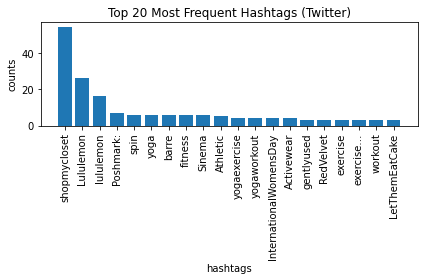

[('shopmycloset', 54), ('Lululemon', 26), ('lululemon', 16), ('Poshmark:', 7), ('spin', 6), ('yoga', 6), ('barre', 6), ('fitness', 6), ('Sinema', 6), ('Athletic', 5), ('yogaexercise', 4), ('yogaworkout', 4), ('InternationalWomensDay', 4), ('Activewear', 4), ('gentlyused', 3), ('RedVelvet', 3), ('exercise', 3), ('exercise…', 3), ('workout', 3), ('LetThemEatCake', 3)]


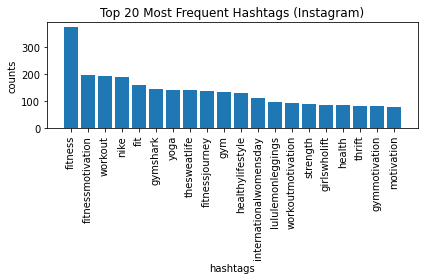

[('fitness', 372), ('fitnessmotivation', 196), ('workout', 191), ('nike', 188), ('fit', 158), ('gymshark', 144), ('yoga', 141), ('thesweatlife', 141), ('fitnessjourney', 137), ('gym', 133), ('healthylifestyle', 130), ('internationalwomensday', 112), ('lululemonleggings', 96), ('workoutmotivation', 93), ('strength', 88), ('girlswholift', 86), ('health', 84), ('thrift', 82), ('gymmotivation', 81), ('motivation', 78)]


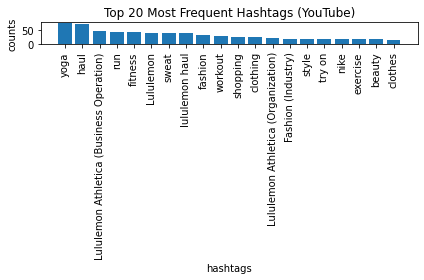

[('yoga', 75), ('haul', 72), ('Lululemon Athletica (Business Operation)', 47), ('run', 43), ('fitness', 43), ('Lululemon', 42), ('sweat', 41), ('lululemon haul', 40), ('fashion', 35), ('workout', 30), ('shopping', 27), ('clothing', 25), ('Lululemon Athletica (Organization)', 23), ('Fashion (Industry)', 20), ('style', 20), ('try on', 18), ('nike', 18), ('exercise', 18), ('beauty', 18), ('clothes', 17)]


In [18]:
get_most_freq_hashtag(df_lst[1:], title_lst[1:])

#### Sensitive Scores

In [13]:
# Function used to process captions by lemmatization and removing punctuations and most/least frequent words
# return the processed captions as pandas series
def processTextCalculateSentiment(df):
    # Remove all hashtags, punctuations, and stopwords
    captions = df['text'].apply(lambda x: " ".join(x.lower() for x in x.split()))
    captions = captions.apply(lambda x: ' '.join(re.sub("(#[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",x) for x in x.split()))
    captions = captions.apply(lambda x: " ".join(x for x in x.split() if x not in nltk.corpus.stopwords.words('english')))
    
    # Remove most 10 common words
    freq = pd.Series(' '.join(captions).split()).value_counts()[:10]
    captions = captions.apply(lambda x: " ".join(x for x in x.split() if x not in list(freq.index)))
    # Remove 10 least frequent words
    least_freq = pd.Series(' '.join(captions).split()).value_counts()[-10:]
    captions = captions.apply(lambda x: " ".join(x for x in x.split() if x not in list(freq.index)))

    # Lemmatization
    captions = captions.apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
    captions.replace('', np.nan, inplace=True)
    captions.dropna(inplace=True)
    
    df['fully_proccessed_tokens'] = captions
    df['sentiment_score'] = df['fully_proccessed_tokens'].apply(lambda x: sentiment_score(str(x)))
    return df

# Function used to compute sentimental score from the input
def sentiment_score(text):
    sid = nltk.sentiment.vader.SentimentIntensityAnalyzer()
    return sid.polarity_scores(text)['compound']

In [14]:
def plotSentimentDistribution(df_list, title_list):
    for i in range(len(df_list)):
        df_list[i] = processTextCalculateSentiment(df_list[i])
        df_list[i]['sentiment_score'].hist()
        plt.xlabel('sentiment score')
        plt.ylabel('counts')
        plt.title('Sentiment Scores for ' + title_list[i])
        print('Average Sentiment Score for ' + title_list[i] + ' is ' + 
              str(df_list[i]['sentiment_score'].sum()/df_list[i].shape[0]))
        plt.show()

Average Sentiment Score for Reddit is 0.27598402714932124


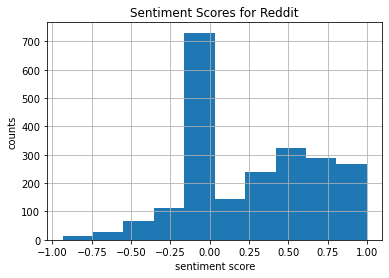

Average Sentiment Score for Twitter is 0.13716678383128295


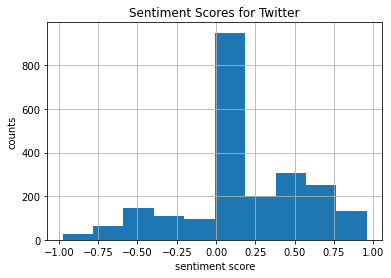

Average Sentiment Score for Instagram is 0.5058331288343558


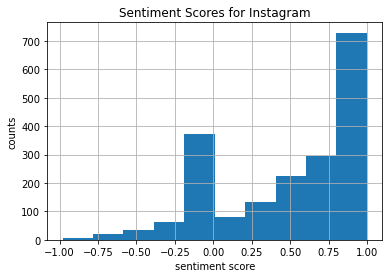

Average Sentiment Score for YouTube is 0.8986775431861804


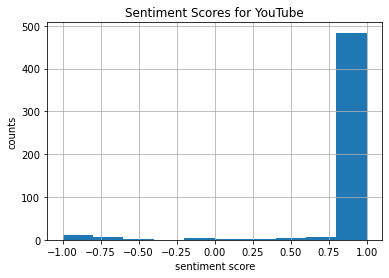

In [15]:
plotSentimentDistribution(df_lst, title_lst)

#### Word Frequency Distribution

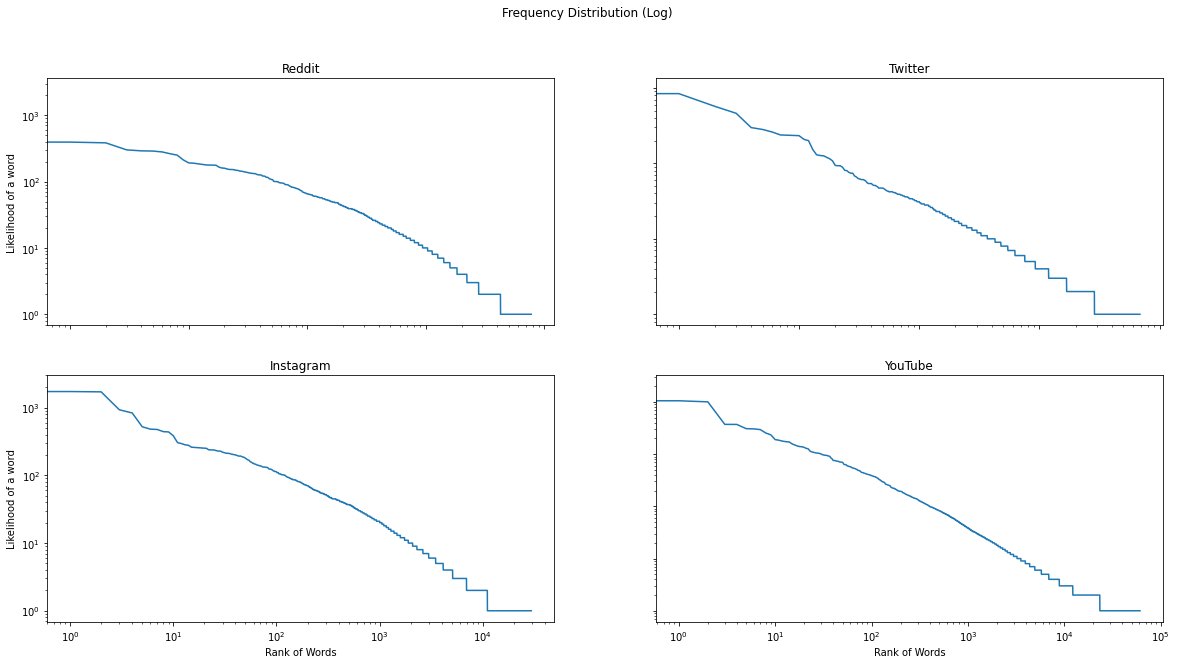

In [22]:
fig, axs = plt.subplots(2, 2, figsize=(20, 10))
fig.suptitle("Frequency Distribution (Log)")

axs[0, 0].plot(range(len(wordsCount_rdt)), wordsCount_rdt['count'])
axs[0, 0].set_title("Reddit")
axs[0, 1].plot(range(len(wordsCount_twt)), wordsCount_twt['count'])
axs[0, 1].set_title("Twitter")

axs[1, 0].plot(range(len(wordsCount_ins)), wordsCount_ins['count'])
axs[1, 0].set_title("Instagram")
axs[1, 1].plot(range(len(wordsCount_ytb)), wordsCount_ytb['count'])
axs[1, 1].set_title("YouTube")

for ax in axs.flat:
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set(xlabel='Rank of Words', ylabel='Likelihood of a word')
    
# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

# set the spacing between subplots 
plt.show()

### Word Concordance

In [16]:
text = nltk.Text(token_twt) #Convert t_data into a Text class of nltk
CIndex = nltk.text.ConcordanceIndex(text) #Load the text into a ConcordanceIndex

In [17]:
# The surrounding words of 'enjoy'
CIndex.print_concordance('best')

Displaying 25 of 38 matches:
ness Zwift an online fitness platform best known for hosting virtual cycling rac
ulemon @americangiant sweatshirts The best @Lars @lululemon This is n't a concer
ululemon Great condition just not the best fit for me 😊 ❤ ️ Definitely not DJing
@poshmarkapp @ermss_h You would be my best friend in real life girl shoes lulule
cute Zwift an online fitness platform best known for hosting virtual cycling rac
hind Zwift an online fitness platform best known for hosting virtual cycling rac
n WHUT AirPod Pros are definitely the best purchase I ’ve made in awhile besides
p @ManojLalu @lululemon Cute cat PLUS best cat name ever @summerdbeauty @Fableti
 We 'd love to support in finding the best bag style to suit your gym needs rest
Swift fabric for us @lululemon Ran my best 5k in Surge joggers so thank YOU 🙏 🏾 
utton closure yoga grocery carr The 7 best high support sports bras for 2021 sup
structor a Brand Ambassador for The 7 best high support sports bras for 2021 sup

In [18]:
text.common_contexts(['fit'])

get_and best_for they_really rlly_a they_me best_in they_snug not_in
to_to


In [19]:
text.count('like')

126

In [20]:
# Make a plot to show each time a set of words occurs
list_of_words = ['love', 'hate', 'like', 'fit', 'worst', 'best', 'good']
token_lst = [token_rdt, token_twt, token_ins, token_ytb]
def plotWordsOccurance(token_list, title_list, df_list):
    for i in range(len(token_list)):
        text = nltk.Text(token_list[i])
        sns.reset_orig()
        nltk.draw.dispersion.dispersion_plot(text, list_of_words, 
                                             title="Word Occurances in {}".format(title_list[i]))
        sns.set()
        
        num_strong_pos = text.count('love') + text.count('best')
        num_strong_neg = text.count('hate') + text.count('worst')
        num_weak_pos = text.count('like') + text.count('good')
        total_words_count = df_list[i]['word_counts'].sum()
        print('Frequency Strong Positive Words: ' + str(num_strong_pos/total_words_count))
        print('Frequency Strong Negative Words: ' + str(num_strong_neg/total_words_count))
        print('Frequency Weak Positive Words: ' + str(num_weak_pos/total_words_count))
        print('Frequency Emotion Words: ' + str((num_weak_pos+num_strong_pos+num_strong_neg)/total_words_count))

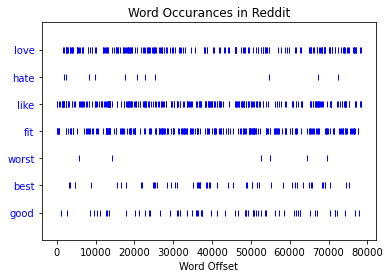

Frequency Strong Positive Words: 0.003159312202195981
Frequency Strong Negative Words: 0.0002201160140874249
Frequency Weak Positive Words: 0.004221048270147089
Frequency Emotion Words: 0.007600476486430495


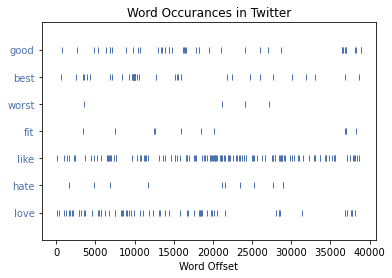

Frequency Strong Positive Words: 0.002731379346570018
Frequency Strong Negative Words: 0.00042021220716461814
Frequency Weak Positive Words: 0.00441222817522849
Frequency Emotion Words: 0.007563819728963126


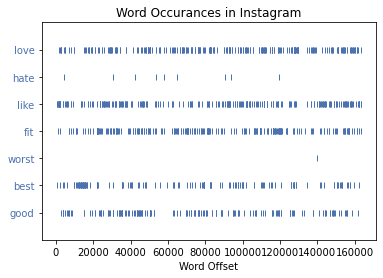

Frequency Strong Positive Words: 0.002616801671421333
Frequency Strong Negative Words: 6.941118491833774e-05
Frequency Weak Positive Words: 0.002783388515225343
Frequency Emotion Words: 0.005469601371565014


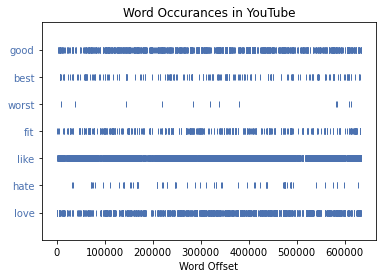

Frequency Strong Positive Words: 0.002353341998006284
Frequency Strong Negative Words: 0.00012933917147219524
Frequency Weak Positive Words: 0.017418200860578683
Frequency Emotion Words: 0.019900882030057163


In [21]:
plotWordsOccurance(token_lst, title_lst, df_lst)

#### Word Distribution

#### (1) word frequency distribution (word lengths)

In [29]:
def wordDistributionLength(df_list, title_list, word_length, num_words=20):
    for i in range(len(df_list)):
        whcfdist = nltk.ConditionalFreqDist(((len(w), w) for w in df_list[i]['normalized_tokens'].sum()))
        whcfdist[word_length].plot(num_words, title=title_list[i])

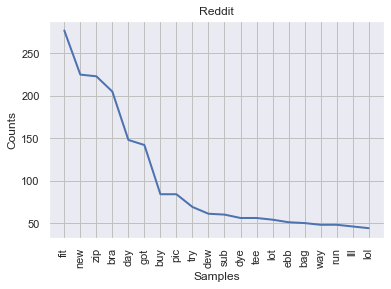

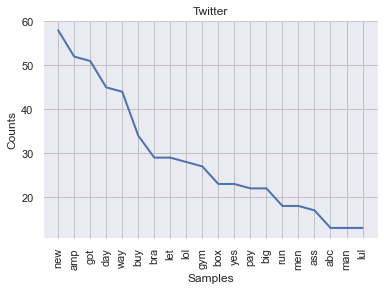

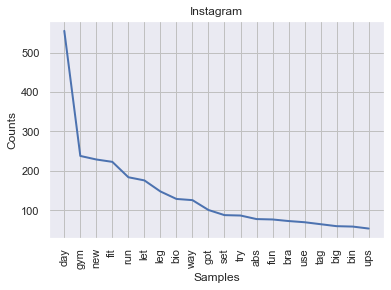

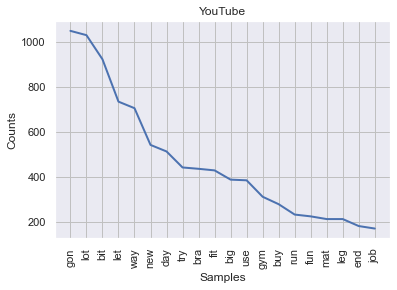

In [30]:
wordDistributionLength(df_lst, title_lst, 3)

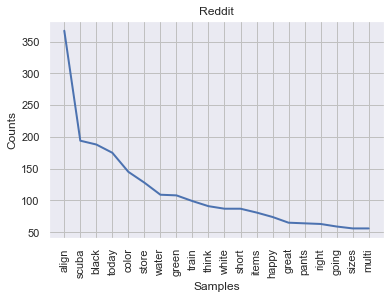

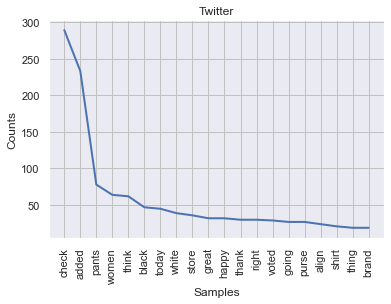

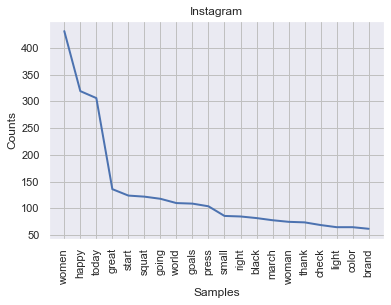

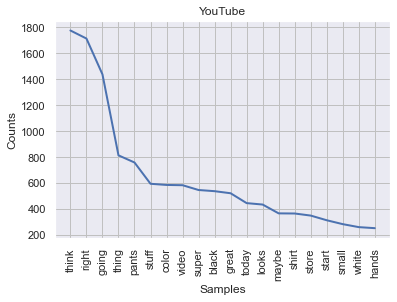

In [31]:
wordDistributionLength(df_lst, title_lst, 5)

#### (2) word frequency distribution (POS)

In [32]:
def wordDistributionPOS(df_list, title_list, pos, num_words=20):
    freqDict = {}
    for i in range(len(df_list)):
        df_list[i]['normalized_tokens_POS'] = [nltk.pos_tag(t) for t in df_list[i]['normalized_tokens']]
        POStoWord = nltk.ConditionalFreqDist((p, w) for w, p in df_list[i]['normalized_tokens_POS'].sum())
        POStoWord[pos].plot(num_words, title=title_list[i])
        freqDict[title_list[i]] = POStoWord[pos].most_common(10)
    return pd.DataFrame(freqDict)

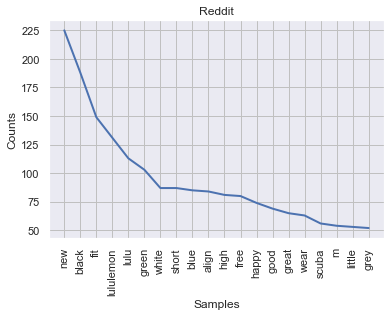

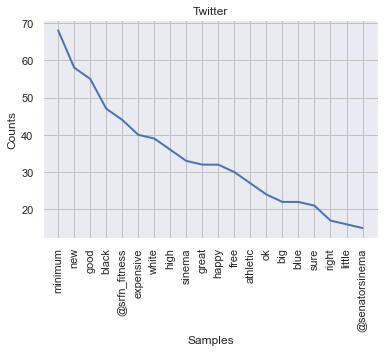

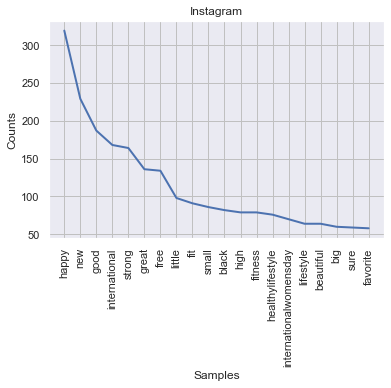

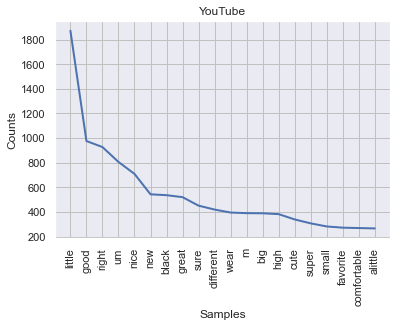

,Reddit,Twitter,Instagram,YouTube
0,"(new, 225)","(minimum, 68)","(happy, 319)","(little, 1872)"
1,"(black, 188)","(new, 58)","(new, 229)","(good, 976)"
2,"(fit, 149)","(good, 55)","(good, 187)","(right, 927)"
3,"(lululemon, 131)","(black, 47)","(international, 168)","(um, 806)"
4,"(lulu, 113)","(@srfn_fitness, 44)","(strong, 164)","(nice, 709)"
5,"(green, 103)","(expensive, 40)","(great, 136)","(new, 543)"
6,"(white, 87)","(white, 39)","(free, 134)","(black, 536)"
7,"(short, 87)","(high, 36)","(little, 98)","(great, 520)"
8,"(blue, 85)","(sinema, 33)","(fit, 91)","(sure, 451)"
9,"(align, 84)","(great, 32)","(small, 86)","(different, 419)"


In [33]:
wordDistributionPOS(df_lst, title_lst, 'JJ')

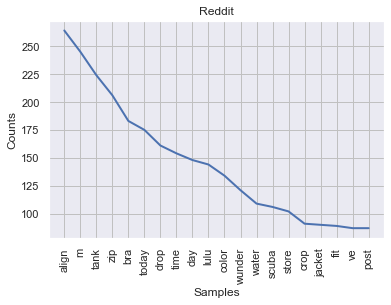

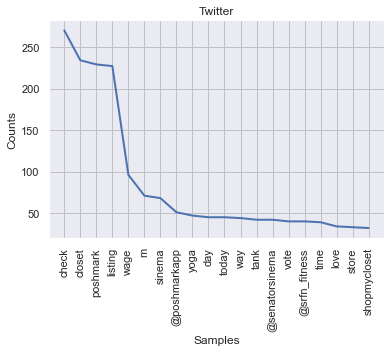

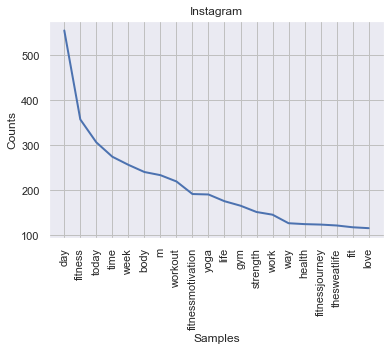

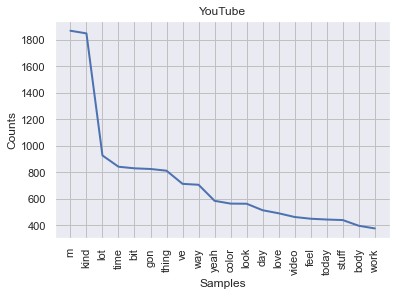

,Reddit,Twitter,Instagram,YouTube
0,"(align, 264)","(check, 270)","(day, 555)","(m, 1867)"
1,"(m, 245)","(closet, 234)","(fitness, 357)","(kind, 1847)"
2,"(tank, 224)","(poshmark, 229)","(today, 306)","(lot, 927)"
3,"(zip, 206)","(listing, 227)","(time, 274)","(time, 842)"
4,"(bra, 183)","(wage, 96)","(week, 256)","(bit, 830)"
5,"(today, 175)","(m, 71)","(body, 240)","(gon, 825)"
6,"(drop, 161)","(sinema, 68)","(m, 233)","(thing, 812)"
7,"(time, 154)","(@poshmarkapp, 51)","(workout, 219)","(ve, 713)"
8,"(day, 148)","(yoga, 47)","(fitnessmotivation, 191)","(way, 706)"
9,"(lulu, 144)","(day, 45)","(yoga, 190)","(yeah, 585)"


In [34]:
wordDistributionPOS(df_lst, title_lst, 'NN')

#### (3) conditional probability distribution (word length)

In [35]:
def wordProbDistribLength(df_list, title_list, word_length):
    most_common = {}
    for i in range(len(df_list)):
        whcfdist = nltk.ConditionalFreqDist(((len(w), w) for w in df_list[i]['normalized_tokens'].sum()))
        whcpdist = nltk.ConditionalProbDist(whcfdist, nltk.ELEProbDist)
        most_common_word = whcpdist[word_length].max()
        most_common[title_list[i]] = [most_common_word, whcpdist[word_length].prob(most_common_word)]
    return pd.DataFrame(most_common)

In [36]:
wordProbDistribLength(df_lst, title_lst, 5)

,Reddit,Twitter,Instagram,YouTube
0,align,check,women,think
1,0.0526542,0.0858286,0.0381588,0.0389773


In [37]:
wordProbDistribLength(df_lst, title_lst, 6)

,Reddit,Twitter,Instagram,YouTube
0,shorts,closet,strong,little
1,0.0363976,0.0928543,0.0165343,0.0478717


#### (4) conditional probability distribution (POS)

In [38]:
def wordProbDistribPOS(df_list, title_list, pos):
    most_common = {}
    for i in range(len(df_list)):
        df_list[i]['normalized_tokens_POS'] = [nltk.pos_tag(t) for t in df_list[i]['normalized_tokens']]
        POStoWord = nltk.ConditionalFreqDist((p, w) for w, p in df_list[i]['normalized_tokens_POS'].sum())
        whcpdist_POStoWord = nltk.ConditionalProbDist(POStoWord, nltk.ELEProbDist)
        most_common_word = whcpdist_POStoWord[pos].max()
        most_common[title_list[i]] = [most_common_word, whcpdist_POStoWord[pos].prob(most_common_word)]
    return pd.DataFrame(most_common)

In [39]:
wordProbDistribPOS(df_lst, title_lst, 'JJ')

,Reddit,Twitter,Instagram,YouTube
0,new,minimum,happy,little
1,0.0270611,0.0174545,0.0181611,0.0269861


In [40]:
wordProbDistribPOS(df_lst, title_lst, 'NN')

,Reddit,Twitter,Instagram,YouTube
0,align,check,day,m
1,0.0161779,0.030141,0.0144633,0.0164409


#### (5) Word Cloud

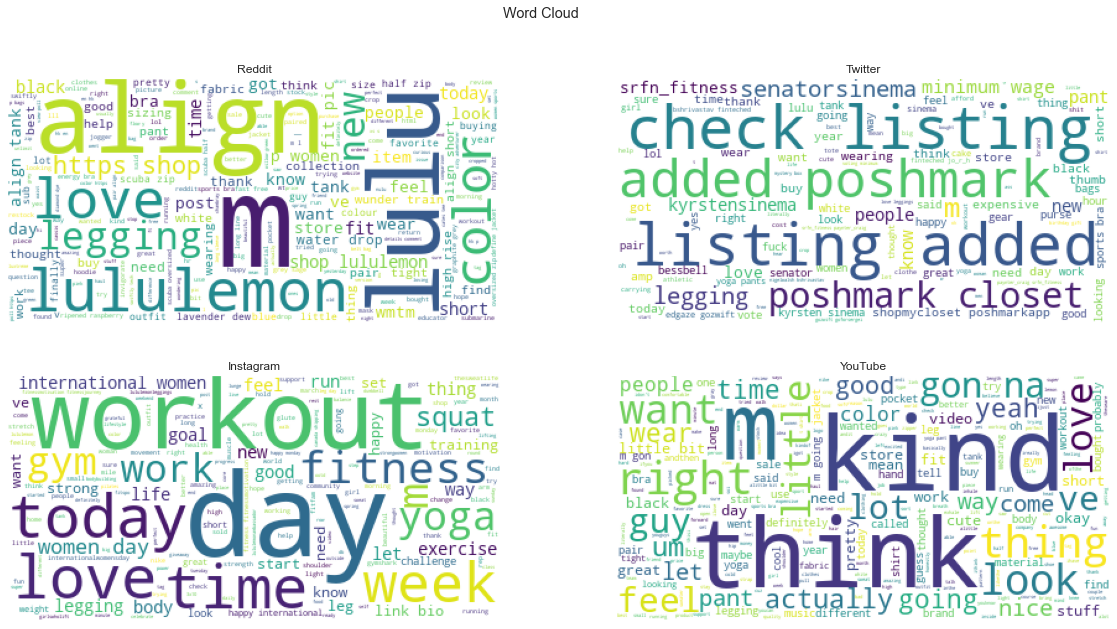

In [41]:
fig, axs = plt.subplots(2, 2, figsize=(20, 10))
fig.suptitle("Word Cloud")

wc_1 = wordcloud.WordCloud(background_color="white", max_words=500, mode='RGBA').generate(' '.join(reddit['normalized_tokens'].sum()))
axs[0, 0].imshow(wc_1)
axs[0, 0].set_title("Reddit")
wc_2 = wordcloud.WordCloud(background_color="white", max_words=500, mode='RGBA').generate(' '.join(twitter['normalized_tokens'].sum()))
axs[0, 1].imshow(wc_2)
axs[0, 1].set_title("Twitter")

wc_3 = wordcloud.WordCloud(background_color="white", max_words=500, mode='RGBA').generate(' '.join(ins['normalized_tokens'].sum()))
axs[1, 0].imshow(wc_3)
axs[1, 0].set_title("Instagram")
wc_4 = wordcloud.WordCloud(background_color="white", max_words=500, mode='RGBA').generate(' '.join(youtube['normalized_tokens'].sum()))
axs[1, 1].imshow(wc_4)
axs[1, 1].set_title("YouTube")

for ax in axs.flat:
    ax.set_xticks([])
    ax.set_yticks([])

#### Bigrams

In [42]:
def bigrams(df_list, title_list):
    bigram_measures = nltk.collocations.BigramAssocMeasures()
    bigram_dict = {}
    for i in range(len(df_list)):
        bigrams = nltk.collocations.BigramCollocationFinder.from_words(df_list[i]['normalized_tokens'].sum())
        bigram_dict[title_list[i]] = bigrams.score_ngrams(bigram_measures.student_t)[:10]
    return pd.DataFrame(bigram_dict)

In [43]:
bigrams(df_lst, title_lst)

,Reddit,Twitter,Instagram,YouTube
0,"((align, tank), 9.91436318754436)","((check, listing), 15.091342875685061)","((➖, ➖), 13.34668904262022)","((gon, na), 32.26325735860367)"
1,"((water, drop), 9.800319710307274)","((listing, added), 14.904562959610969)","((women, day), 12.144271747421897)","((little, bit), 23.751062119030816)"
2,"((fit, pic), 8.530429831970299)","((added, poshmark), 14.901242007935556)","((⁣, ⁣), 11.90800477897252)","((m, going), 19.032755757808804)"
3,"((lavender, dew), 7.796755809846001)","((poshmark, closet), 14.898687155627325)","((international, women), 11.887797340107642)","((m, gon), 17.05177060452849)"
4,"((half, zip), 7.754089328433032)","((minimum, wage), 8.547084809419394)","((=, =), 11.157848060041985)","((sports, bra), 12.327848665609238)"
5,"((scuba, zip), 7.597513654720908)","((shopmycloset, @poshmarkapp), 7.3263208177420...","((link, bio), 10.656691390785634)","((alittle, bit), 12.028837413289185)"
6,"((ripened, raspberry), 7.47011225858073)","((kyrsten, sinema), 6.123129847047934)","((happy, international), 10.283789339923386)","((yoga, pants), 10.381522097583899)"
7,"((grey, sage), 7.238633731541507)","((@edgaze, @gozwift), 4.8913355382360315)","((fitness, fitnessmotivation), 8.363287104531347)","((t, shirt), 8.979761110456979)"
8,"((high, rise), 7.120369514302697)","((@bshrivastav, @finteched), 4.789369438813803)","((fitnessmotivation, fitnessjourney), 7.167106...","((sports, bras), 8.696390192072132)"
9,"((wunder, trains), 6.831647476182369)","((yoga, pants), 4.73370127339084)","((happy, monday), 7.000194205917054)","((m, wearing), 8.590392412859556)"


#### Trigrams

In [44]:
def trigrams(df_list, title_list):
    trigram_measures = nltk.collocations.TrigramAssocMeasures()
    trigram_dict = {}
    for i in range(len(df_list)):
        trigrams = nltk.collocations.TrigramCollocationFinder.from_words(df_list[i]['normalized_tokens'].sum())
        trigram_dict[title_list[i]] = trigrams.score_ngrams(trigram_measures.student_t)[:10]
    return pd.DataFrame(trigram_dict)

In [45]:
trigrams(df_lst, title_lst)

,Reddit,Twitter,Instagram,YouTube
0,"((scuba, half, zip), 5.744168917374132)","((listing, added, poshmark), 15.097159976066497)","((➖, ➖, ➖), 12.922772647095533)","((m, gon, na), 17.717465743062316)"
1,"((view, poll](https://www.reddit.com, poll), 5...","((added, poshmark, closet), 15.097149299919794)","((international, women, day), 11.74687685876449)","((today, m, going), 6.24075729149738)"
2,"((scuba, oversized, zip), 4.999492622828742)","((check, listing, added), 15.096635102745367)","((=, =, =), 10.954411880949632)","((gon, na, try), 5.290255372216721)"
3,"((blissful, bend, tank), 3.9999719870121133)","((@bshrivastav, @finteched, @jo_r_h), 4.582567...","((happy, international, women), 9.591336929593...","((m, going, ahead), 4.580454084986729)"
4,"((pace, rival, skirt), 3.872979675020463)","((@edgaze, @gozwift, @goforsergei), 4.35888923...","((⁣, ⁣, ⁣), 8.245731420731401)","((m, going, tobe), 4.47106895951992)"
5,"((city, adventurer, backpack), 3.872973130730676)","((mystery, box, 🎁), 4.242630235250545)","((fitness, fitnessmotivation, fitnessjourney),...","((hope, guys, enjoyed), 4.242546941867132)"
6,"((international, women, day), 3.8729703871454944)","((poshmark, closet, 🎁), 4.241216708364622)","((▃, ▃, ▃), 5.999998555495551)","((abby, today, m), 4.1229624920032535)"
7,"((white, align, tank), 3.871562177109707)","((@gozwift, @goforsergei, @jenny__watts), 4.12...","((▪, ️◾️, ▪), 5.916072399525329)","((soi'm, gon, na), 4.122950253613972)"
8,"((flow, y, bra), 3.605442777144655)","((@nigelwalsh, @bshrivastav, @finteched), 3.99...","((armworkout, workoutroutine, workouts), 5.385...","((gon, na, ahead), 4.122516657324606)"
9,"((power, pivot, tank), 3.46408414796717)","((box, 🎁, check), 3.999822010023431)","((cardio, hiitworkout, hiit), 5.385160085831707)","((gon, na, wear), 4.119850040145011)"


#### KL Divergence

In [22]:
rdt_words = set(reddit['normalized_tokens'].sum())
twt_words = set(twitter['normalized_tokens'].sum())
ins_words = set(ins['normalized_tokens'].sum())
ytb_words = set(youtube['normalized_tokens'].sum())

overlapWords = rdt_words & twt_words & ins_words & ytb_words
overlapWordsDict = {word: index for index, word in enumerate(overlapWords)}

In [23]:
def makeProbsArray(dfColumn, overlapDict):
    words = dfColumn.sum()
    countList = [0] * len(overlapDict)
    for word in words:
        try:
            countList[overlapDict[word]] += 1
        except KeyError:
            #The word is not common so we skip it
            pass
    countArray = np.array(countList)
    return countArray / countArray.sum()

rdtProbArray = makeProbsArray(reddit['normalized_tokens'], overlapWordsDict)
twtProbArray = makeProbsArray(twitter['normalized_tokens'], overlapWordsDict)
insProbArray = makeProbsArray(ins['normalized_tokens'], overlapWordsDict)
ytbProbArray = makeProbsArray(youtube['normalized_tokens'], overlapWordsDict)

In [24]:
# Calculate divergences
rdt_twt_divergence = scipy.stats.entropy(rdtProbArray, twtProbArray)
print("Reddit & Twitter: {}".format(rdt_twt_divergence))
rdt_ins_divergence = scipy.stats.entropy(rdtProbArray, insProbArray)
print("Reddit & Instagra: {}".format(rdt_ins_divergence))
rdt_ytb_divergence = scipy.stats.entropy(rdtProbArray, ytbProbArray)
print("Reddit & YouTube: {}".format(rdt_ytb_divergence))

twt_ins_divergence = scipy.stats.entropy(twtProbArray, insProbArray)
print("Twitter & Instagram: {}".format(twt_ins_divergence))
twt_ytb_divergence = scipy.stats.entropy(twtProbArray, ytbProbArray)
print("Twitter & YouTube: {}".format(twt_ytb_divergence))
ins_ytb_divergence = scipy.stats.entropy(insProbArray, ytbProbArray)
print("Instagram & YouTube: {}".format(ins_ytb_divergence))

Reddit & Twitter: 0.6567346289706764
Reddit & Instagra: 0.7463943386188027
Reddit & YouTube: 0.7816715139268676
Twitter & Instagram: 0.8297263339816323
Twitter & YouTube: 1.0188312439650222
Instagram & YouTube: 0.8089016943625817


In [25]:
from IPython.display import display

# Elementwise calculation and see which words best distinguish the two corpora
def wordMostDistinguish(probArray_list, title_list, num_words=10):
    kl_df = pd.DataFrame(list(overlapWordsDict.keys()), columns = ['word'], index = list(overlapWordsDict.values()))
    kl_df = kl_df.sort_index()
    for i in range(len(probArray_list)):
        print(title_list[i])
        result = {}
        for j in range(len(probArray_list)):
            if (probArray_list[j] != probArray_list[i]).all():
                divergence_ew = scipy.special.kl_div(probArray_list[j], probArray_list[i])
                wd_df = kl_df
                wd_df['elementwise divergence'] = divergence_ew
                wd_df = wd_df.sort_values(by='elementwise divergence', ascending=False)[:num_words]
                wd_df[" vs. " + title_list[j]] = wd_df['word'] + ", " + wd_df['elementwise divergence'].astype(str)
                wd_df.drop(columns=['word', 'elementwise divergence'], inplace=True)
                wd_df.reset_index(drop=True, inplace=True)
                result.update(wd_df.to_dict())
        display(pd.DataFrame.from_dict(result))

In [26]:
probArray_lst = [rdtProbArray, twtProbArray, insProbArray, ytbProbArray]
wordMostDistinguish(probArray_lst, title_lst)

Reddit


,vs. Twitter,vs. Instagram,vs. YouTube
0,"check, 0.0847878597369336","fitness, 0.031876209277884295","gon, 0.02294191582289125"
1,"added, 0.0774559049075749","workout, 0.01792551010679765","na, 0.02294191582289125"
2,"poshmark, 0.057086634244872904","women, 0.01606341033195027","kind, 0.02067664231170966"
3,"closet, 0.05493889486446243","nike, 0.01458619301473204","yeah, 0.01822072577984701"
4,"minimum, 0.03970109456247896","exercise, 0.011407109665071016","little, 0.015205794930233931"
5,"carrying, 0.026338949950008357","align, 0.01053759016060967","align, 0.012967235771132854"
6,"$, 0.016065250092149572","strength, 0.009708838885007762","video, 0.01237272142917323"
7,"align, 0.008534108508150458","$, 0.00970326759930466","right, 0.0116731532152035"
8,"purse, 0.008428128293218966","squats, 0.007996826011353231","guys, 0.008965984605519485"
9,"fit, 0.007823673634286404","strong, 0.007878128952282857","going, 0.008777883559072218"


Twitter


,vs. Reddit,vs. Instagram,vs. YouTube
0,"check, 0.025726916629529147","check, 0.02124662380612389","kind, 0.029426428656505917"
1,"added, 0.021339968141251324","closet, 0.020746113919147328","poshmark, 0.022903921266909086"
2,"poshmark, 0.020028841364174956","added, 0.019839787046338698","check, 0.02246742362487958"
3,"closet, 0.01960506782265902","poshmark, 0.018769480010718438","closet, 0.02243687736903165"
4,"fit, 0.01667012959226988","workout, 0.013657917355608102","added, 0.022272403220868667"
5,"align, 0.01567291761682128","shipping, 0.01281666609835586","little, 0.020229775063960606"
6,"zip, 0.015192334874688875","=, 0.011432750850531444","guys, 0.016846447952483502"
7,"scuba, 0.014647349366706459","body, 0.010649089492595739","bit, 0.013149437088064177"
8,"aligns, 0.012680548708113588","fitness, 0.009563231751039403","okay, 0.012178494823051845"
9,"drop, 0.010375389174169417","squat, 0.008865139894727191","na, 0.01061824893983566"


Instagram


,vs. Reddit,vs. Twitter,vs. YouTube
0,"scuba, 0.028226090385560083","closet, 0.0659909292912188","yeah, 0.029243612157495814"
1,"align, 0.02262462833079406","added, 0.0584480298046278","kind, 0.02752994583892779"
2,"zip, 0.02134468521681371","check, 0.04972696910033713","think, 0.020067127772745677"
3,"aligns, 0.01639309088320339","poshmark, 0.04789715728518495","guys, 0.01682265509362688"
4,"fitness, 0.0108416285020115","minimum, 0.03693092770815437","gon, 0.015711688031807967"
5,"tank, 0.009127682777546817","carrying, 0.021754487029492026","na, 0.015711688031807967"
6,"workout, 0.00911847199348683","expensive, 0.015511270865613533","little, 0.012913044597362894"
7,"lulu, 0.008001673467626253","pants, 0.010318546214429847","right, 0.012632994698985673"
8,"women, 0.007873202921041912","workers, 0.009436495321082714","actually, 0.011004480845054744"
9,"grey, 0.007852201168515597","voted, 0.008390011394408588","fitness, 0.009629675735058685"


YouTube


,vs. Reddit,vs. Twitter,vs. Instagram
0,"align, 0.03649887700060033","poshmark, 0.10776806556208957","fitness, 0.023306670121790177"
1,"aligns, 0.03247161625203035","added, 0.10249860992891614","=, 0.02171148879823867"
2,"wunder, 0.02518754133754153","closet, 0.09896320878236226","women, 0.017257323241437517"
3,"scuba, 0.01888891018921292","check, 0.05650067261480242","international, 0.017141812297065656"
4,"lulu, 0.017824629206816735","minimum, 0.04824669409177437","shipping, 0.012912293965648023"
5,"pic, 0.017628859277274523","carrying, 0.021478790106530716","workout, 0.012230646695965835"
6,"zip, 0.012611731982512853","$, 0.017341593572417612","dm, 0.01203703016376154"
7,"grey, 0.012097468006253284","voted, 0.011929371264148702","kind, 0.01137787796966671"
8,"drop, 0.010865606786540107","kind, 0.011705749554564965","$, 0.010637684736880775"
9,"hr, 0.010116464212573778","leggings, 0.010779912052320824","happy, 0.010543203175798276"


In [27]:
# Functions to calculate divergence and distances.
def kl_divergence(X, Y):
    P = X.copy()
    Q = Y.copy()
    P.columns = ['P']
    Q.columns = ['Q']
    df = Q.join(P).fillna(0)
    p = df.iloc[:,1]
    q = df.iloc[:,0]
    D_kl = scipy.stats.entropy(p, q)
    return D_kl

def chi2_divergence(X,Y):
    P = X.copy()
    Q = Y.copy()
    P.columns = ['P']
    Q.columns = ['Q']
    df = Q.join(P).fillna(0)
    p = df.iloc[:,1]
    q = df.iloc[:,0]
    return scipy.stats.chisquare(p, q).statistic

def Divergence(corpus1, corpus2, difference="KL"):
    """Difference parameter can equal KL, Chi2, or Wass"""
    freqP = nltk.FreqDist(corpus1)
    P = pd.DataFrame(list(freqP.values()), columns = ['frequency'], index = list(freqP.keys()))
    freqQ = nltk.FreqDist(corpus2)
    Q = pd.DataFrame(list(freqQ.values()), columns = ['frequency'], index = list(freqQ.keys()))
    if difference == "KL":
        return kl_divergence(P, Q)
    elif difference == "Chi2":
        return chi2_divergence(P, Q)
    elif difference == "KS":
        try:
            return scipy.stats.ks_2samp(P['frequency'], Q['frequency']).statistic
        except:
            return scipy.stats.ks_2samp(P['frequency'], Q['frequency'])
    elif difference == "Wasserstein":
        try:
            return scipy.stats.wasserstein_distance(P['frequency'], Q['frequency'], u_weights=None, v_weights=None).statistic
        except:
            return scipy.stats.wasserstein_distance(P['frequency'], Q['frequency'], u_weights=None, v_weights=None)

#### KL Distance

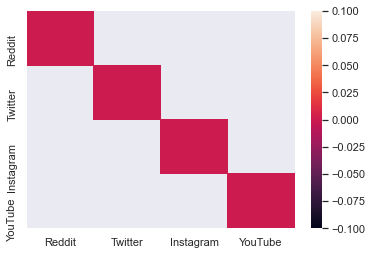

In [52]:
# Plot KL distances heatmap
L = []
for p in df_lst:
    l = []
    for q in df_lst:
        l.append(Divergence(p['text'],q['text'], difference = 'KL'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pd.DataFrame(M, columns = title_lst, index = title_lst)
ax = sns.heatmap(div)
plt.show()

#### $\chi^2$ Distance

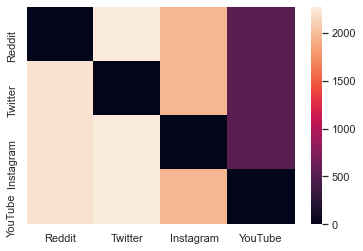

In [53]:
L = []
for p in df_lst:
    l = []
    for q in df_lst:
        l.append(Divergence(p['text'],q['text'], difference='Chi2'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pd.DataFrame(M, columns = title_lst, index = title_lst)
ax = sns.heatmap(div)
plt.show()

#### KS Distance

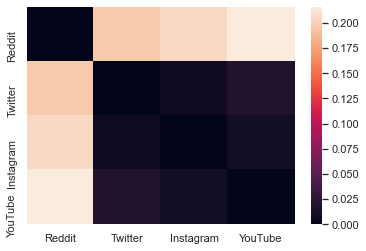

In [54]:
L = []
for p in df_lst:
    l = []
    for q in df_lst:
        l.append(Divergence(p['text'],q['text'], difference='KS'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pd.DataFrame(M, columns = title_lst, index = title_lst)
ax = sns.heatmap(div)
plt.show()

#### Wasserstein Distance

             Reddit   Twitter  Instagram   YouTube
Reddit     0.000000  0.207840   0.217449  0.223699
Twitter    0.207840  0.000000   0.012921  0.031264
Instagram  0.217449  0.012921   0.000000  0.018750
YouTube    0.223699  0.031264   0.018750  0.000000


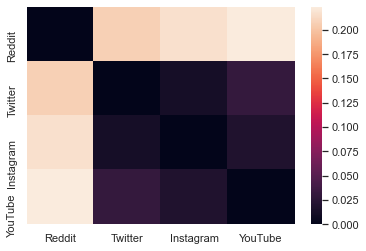

In [30]:
L = []
for p in df_lst:
    l = []
    for q in df_lst:
        l.append(Divergence(p['text'],q['text'], difference='Wasserstein'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pd.DataFrame(M, columns = title_lst, index = title_lst)
print(div)
ax = sns.heatmap(div)
plt.show()

#### Multidimensional Scaling

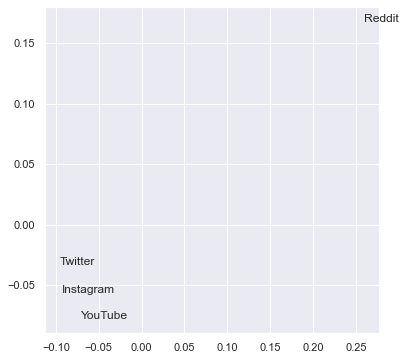

In [31]:
mds = sklearn.manifold.MDS()
pos = mds.fit(M).embedding_
x = pos[:,0]
y = pos[:,1]
fig, ax = plt.subplots(figsize = (6,6))
plt.plot(x, y, ' ')
for i, txt in enumerate(title_lst):
    ax.annotate(txt, (x[i],y[i]))

#### Jensen-Shannon Divergence

In [57]:
# Calculate Jensen-Shannon Divergences
rdt_twt_JSD = scipy.spatial.distance.jensenshannon(rdtProbArray, twtProbArray)
print("Reddit & Twitter: {}".format(rdt_twt_JSD))
rdt_ins_JSD = scipy.spatial.distance.jensenshannon(rdtProbArray, insProbArray)
print("Reddit & Instagram: {}".format(rdt_ins_JSD))
rdt_ytb_JSD = scipy.spatial.distance.jensenshannon(rdtProbArray, ytbProbArray)
print("Reddit & YouTube: {}\n".format(rdt_ytb_JSD))

twt_ins_JSD = scipy.spatial.distance.jensenshannon(twtProbArray, insProbArray)
print("Twitter & Instagram: {}".format(twt_ins_JSD))
twt_ytb_JSD = scipy.spatial.distance.jensenshannon(twtProbArray, ytbProbArray)
print("Twitter & YouTube: {}".format(twt_ytb_JSD))
ins_ytb_JSD = scipy.spatial.distance.jensenshannon(insProbArray, ytbProbArray)
print("Instagram & YouTube: {}\n".format(ins_ytb_JSD))

Reddit & Twitter: 0.38704238609333835
Reddit & Instagram: 0.39555468156319973
Reddit & YouTube: 0.37587289369291543

Twitter & Instagram: 0.39301927341951587
Twitter & YouTube: 0.3952798114732212
Instagram & YouTube: 0.3946725755488842



## Discovering Patterns: Clusters & Topics 

#### Selecting Cluster Number

In [58]:
def getTFVects(df):
    TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.50, max_features=1000, 
                                                           min_df=3, stop_words='english', norm='l2')
    TFVects = TFVectorizer.fit_transform(df['text'])
    return TFVectorizer, TFVects

In [59]:
from sklearn.cluster import KMeans
def plotSilhouette_revised(n_clusters, X, reduced_data):
    
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15,5))
    
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    
    silhouette_avg = sklearn.metrics.silhouette_score(X, cluster_labels)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = sklearn.metrics.silhouette_samples(X, cluster_labels)

    y_lower = 10
    
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = matplotlib.cm.get_cmap("nipy_spectral")
        color = cmap(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10
    
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    cmap = matplotlib.cm.get_cmap("nipy_spectral")
    colors = cmap(float(i) / n_clusters)
    ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    projected_centers = pca.transform(centers)
    # Draw white circles at cluster centers
    ax2.scatter(projected_centers[:, 0], projected_centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(projected_centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("PC 1")
    ax2.set_ylabel("PC 2")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.show()
    print("For n_clusters = {}, The average silhouette_score is : {:.3f}".format(n_clusters, silhouette_avg))

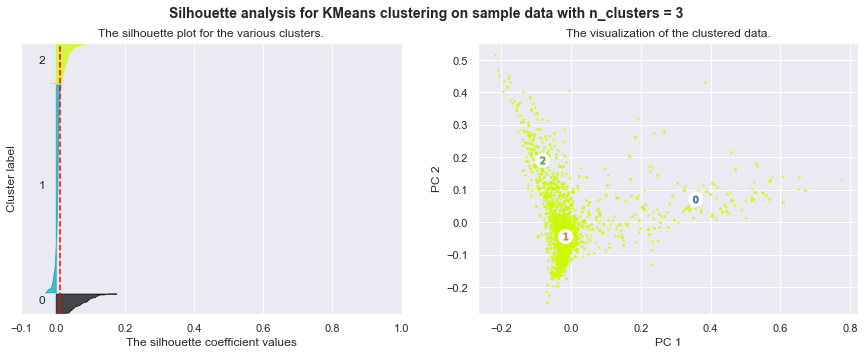

For n_clusters = 3, The average silhouette_score is : 0.012


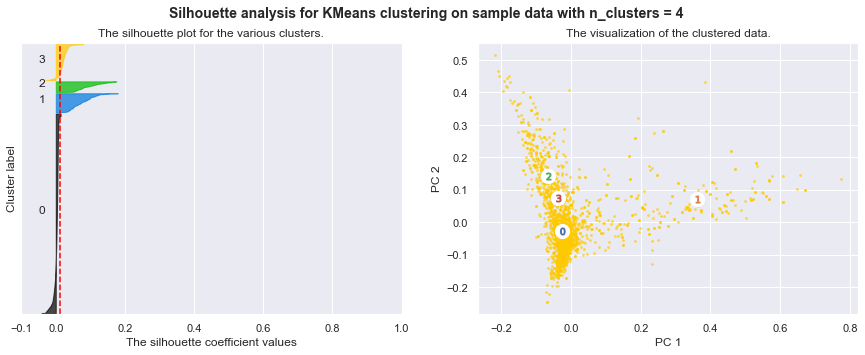

For n_clusters = 4, The average silhouette_score is : 0.013


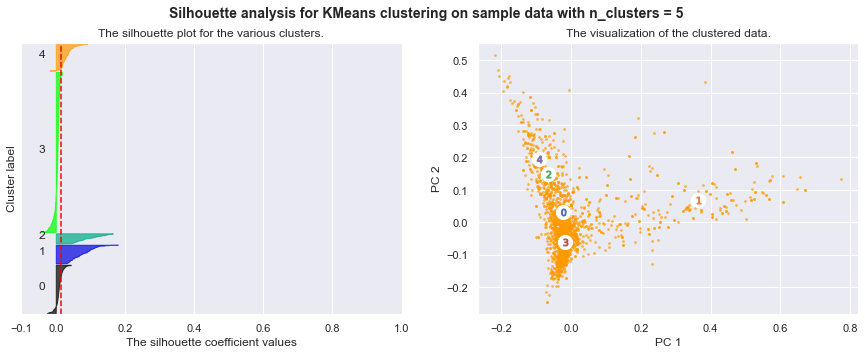

For n_clusters = 5, The average silhouette_score is : 0.016


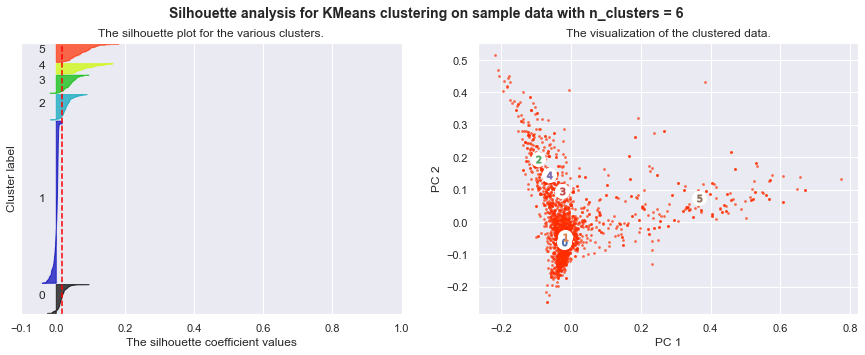

For n_clusters = 6, The average silhouette_score is : 0.017


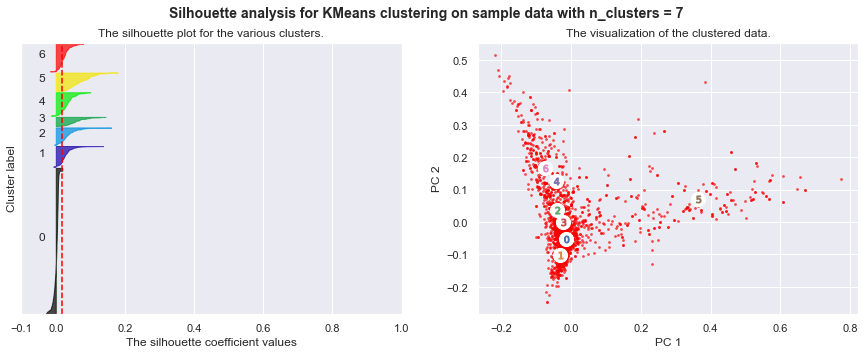

For n_clusters = 7, The average silhouette_score is : 0.018


In [60]:
cluster_num = [3, 4, 5, 6, 7]
rdtTFVectorizer, rdtTFVects = getTFVects(reddit)
for n in cluster_num:
    PCA = sklearn.decomposition.PCA
    pca = PCA(n_components=n).fit(rdtTFVects.toarray())
    reduced_data = pca.transform(rdtTFVects.toarray())
    X = rdtTFVects.toarray()
    plotSilhouette_revised(n, X, reduced_data)

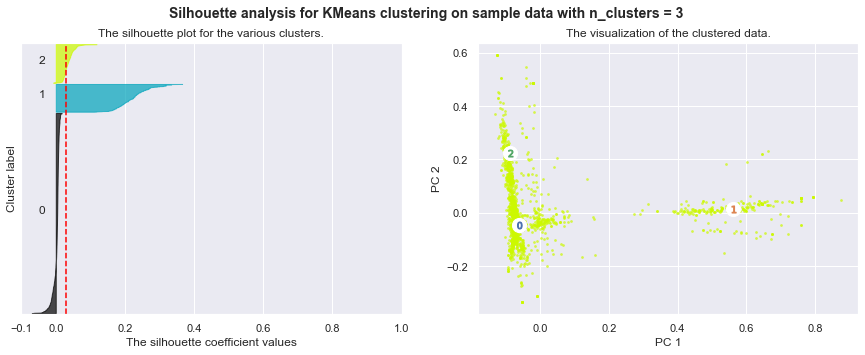

For n_clusters = 3, The average silhouette_score is : 0.030


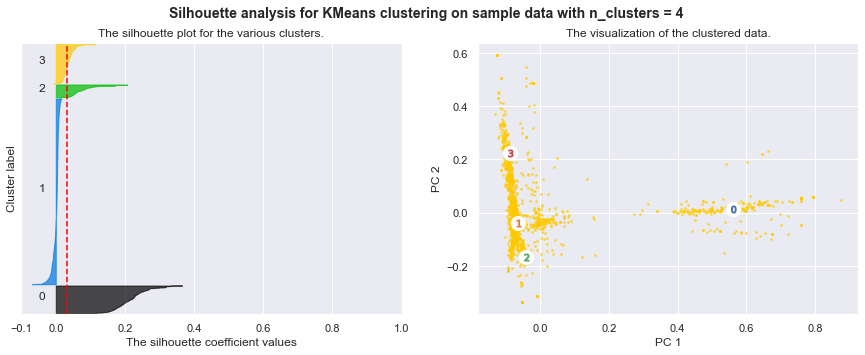

For n_clusters = 4, The average silhouette_score is : 0.032


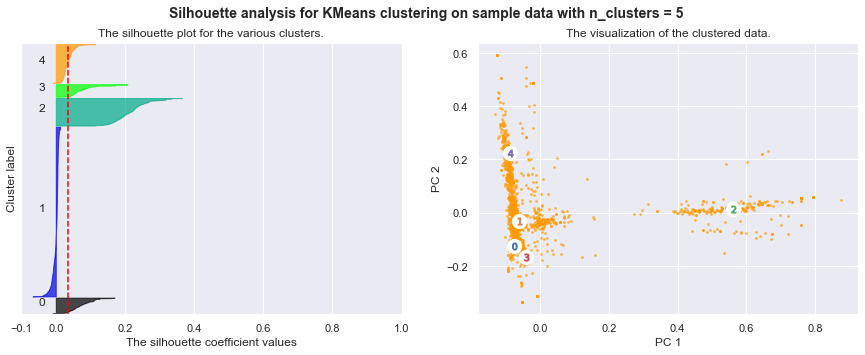

For n_clusters = 5, The average silhouette_score is : 0.036


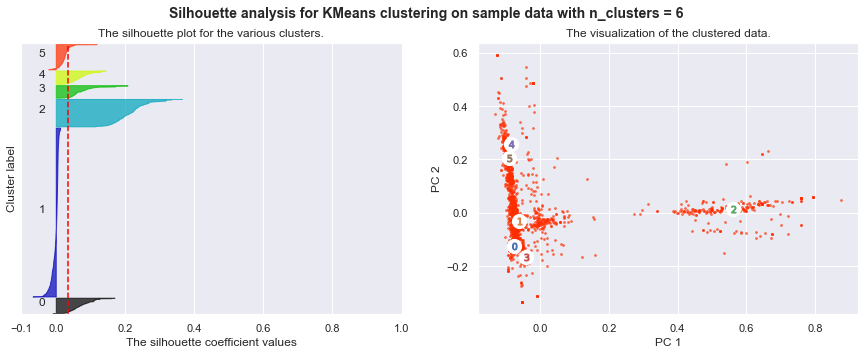

For n_clusters = 6, The average silhouette_score is : 0.036


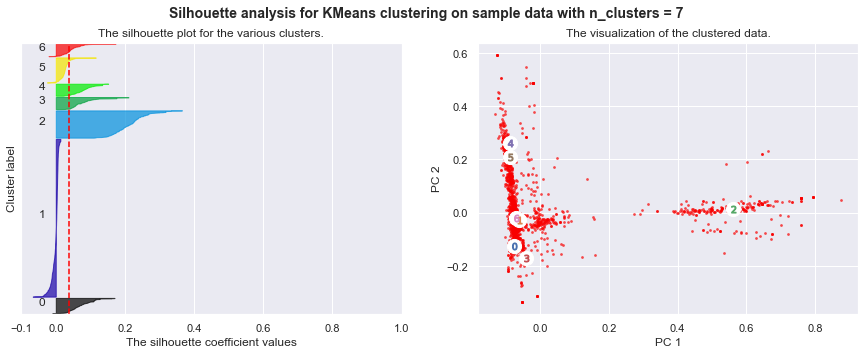

For n_clusters = 7, The average silhouette_score is : 0.038


In [61]:
twtTFVectorizer, twtTFVects = getTFVects(twitter)
for n in cluster_num:
    PCA = sklearn.decomposition.PCA
    pca = PCA(n_components=n).fit(twtTFVects.toarray())
    reduced_data = pca.transform(twtTFVects.toarray())
    X = twtTFVects.toarray()
    plotSilhouette_revised(n, X, reduced_data)

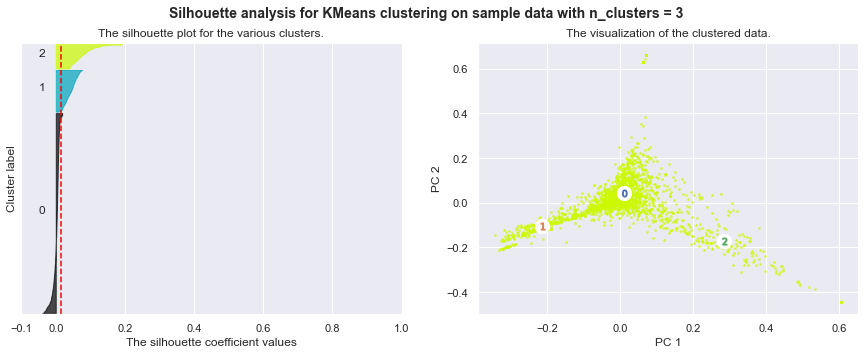

For n_clusters = 3, The average silhouette_score is : 0.015


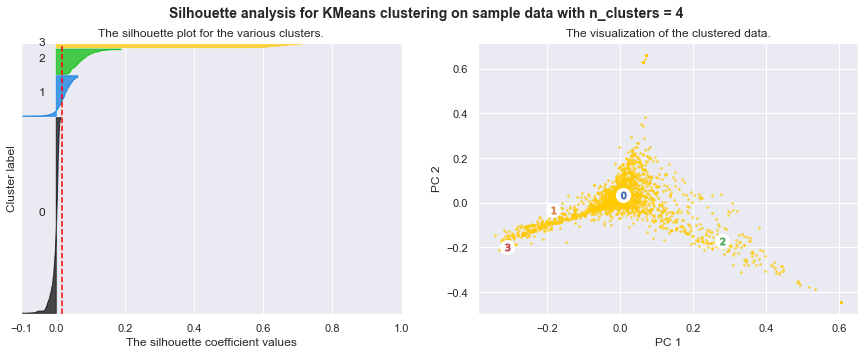

For n_clusters = 4, The average silhouette_score is : 0.017


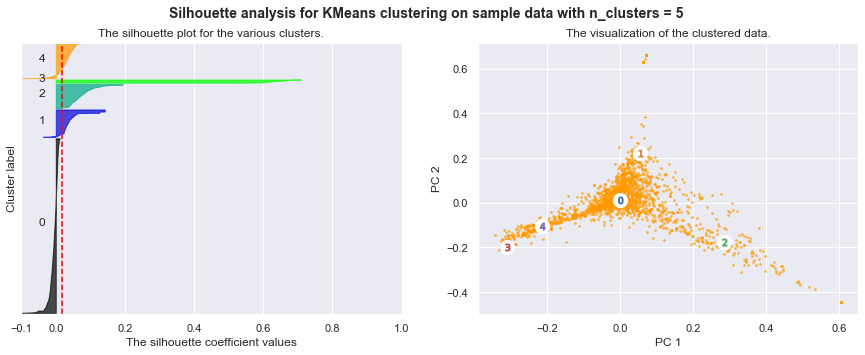

For n_clusters = 5, The average silhouette_score is : 0.019


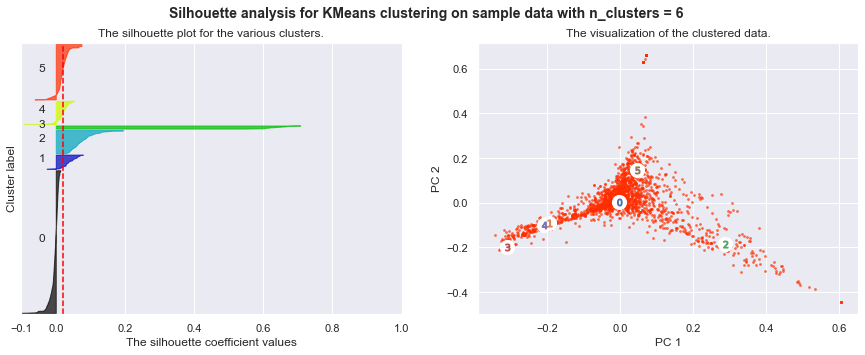

For n_clusters = 6, The average silhouette_score is : 0.020


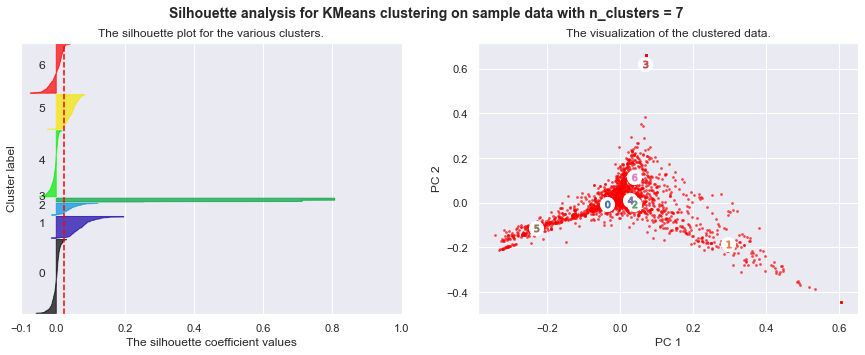

For n_clusters = 7, The average silhouette_score is : 0.024


In [62]:
insTFVectorizer, insTFVects = getTFVects(ins)
for n in cluster_num:
    PCA = sklearn.decomposition.PCA
    pca = PCA(n_components=n).fit(insTFVects.toarray())
    reduced_data = pca.transform(insTFVects.toarray())
    X = insTFVects.toarray()
    plotSilhouette_revised(n, X, reduced_data)

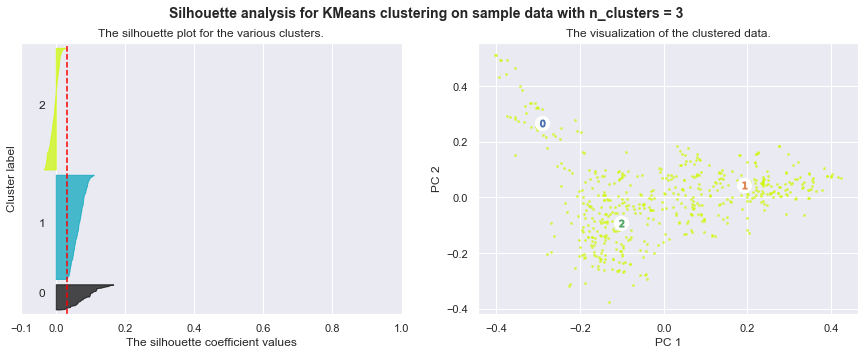

For n_clusters = 3, The average silhouette_score is : 0.033


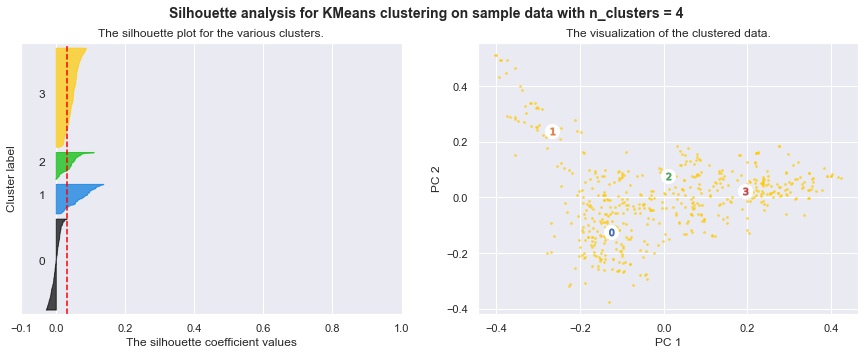

For n_clusters = 4, The average silhouette_score is : 0.032


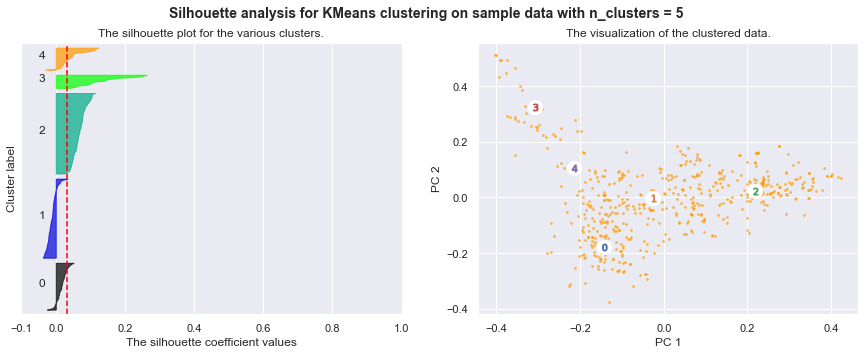

For n_clusters = 5, The average silhouette_score is : 0.033


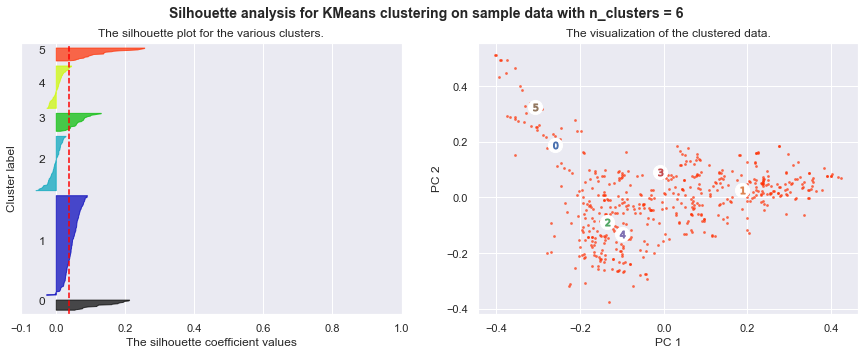

For n_clusters = 6, The average silhouette_score is : 0.038


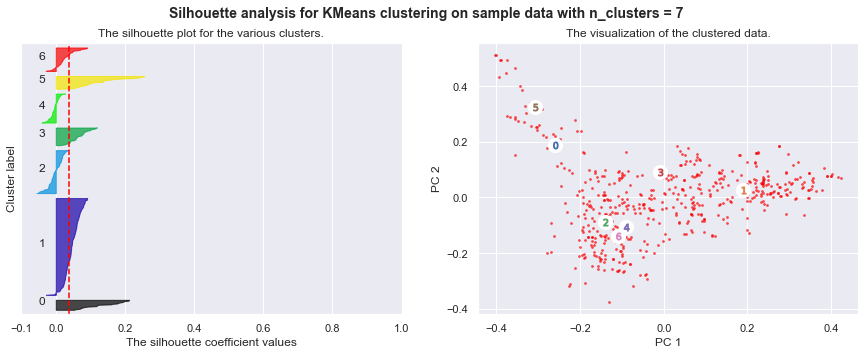

For n_clusters = 7, The average silhouette_score is : 0.039


In [63]:
ytbTFVectorizer, ytbTFVects = getTFVects(youtube)
for n in cluster_num:
    PCA = sklearn.decomposition.PCA
    pca = PCA(n_components=n).fit(ytbTFVects.toarray())
    reduced_data = pca.transform(ytbTFVects.toarray())
    X = ytbTFVects.toarray()
    plotSilhouette_revised(n, X, reduced_data)

#### Flat Clustering with $K$-means

In [64]:
colordict = {0: 'plum', 1: 'orange', 2: 'yellow', 3: 'green', 4: 'blue', 5: 'red', 6: 'purple'}
def kMeanClustering(df, n):
    TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.50, max_features=1000, 
                                                           min_df=3, stop_words='english', norm='l2')
    TFVects = TFVectorizer.fit_transform(df['text'])
    km = sklearn.cluster.KMeans(n_clusters=n, init='k-means++')
    km.fit(TFVects.toarray())
    
    print("Evaluations")
    print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(df['text'], km.labels_)))
    print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(df['text'], km.labels_)))
    print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(df['text'], km.labels_)))
    print("Adjusted Rand Score: {:0.3f}\n".format(sklearn.metrics.adjusted_rand_score(df['text'], km.labels_)))
    
    # Distinguish features of the clusters
    print("Top terms per cluster:")
    terms = TFVectorizer.get_feature_names()
    order_centroids = km.cluster_centers_.argsort()[:, ::-1]
    for i in range(n):
        print("Cluster %d:" % i)
        for ind in order_centroids[i, :10]:
            print(' %s' % terms[ind])
        print('\n')
    
    df['kmeans_predictions'] = km.labels_
    colors = [colordict[c] for c in df['kmeans_predictions']]
    
    PCA = sklearn.decomposition.PCA
    pca = PCA(n_components=n).fit(TFVects.toarray())
    reduced_data = pca.transform(TFVects.toarray())
    components = pca.components_
    keyword_ids = list(set(order_centroids[:,:5].flatten()))
    words = [terms[i] for i in keyword_ids]
    x = components[:,keyword_ids][0,:]
    y = components[:,keyword_ids][1,:]
    
    fig = plt.figure(figsize = (16, 9))
    ax = fig.add_subplot(111)
    ax.set_frame_on(False)
    ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.3, label = colors)
    for i, word in enumerate(words):
        ax.annotate(word, (x[i],y[i]))   
    plt.xticks(())
    plt.yticks(())
    plt.title('True Classes')
    plt.show()
    return df

Evaluations
Homogeneity: 0.176
Completeness: 1.000
V-measure: 0.300
Adjusted Rand Score: 0.001

Top terms per cluster:
Cluster 0:
 lulu
 lululemon
 just
 today
 like
 shorts
 know
 bra
 leggings
 ve


Cluster 1:
 zip
 scuba
 oversized
 half
 black
 xs
 raspberry
 grey
 ripened
 restock


Cluster 2:
 size
 align
 bra
 like
 grey
 25
 multi
 sizing
 time
 train


Cluster 3:
 align
 tank
 fit
 pic
 shorts
 crop
 black
 blissful
 bend
 short


Cluster 4:
 drop
 water
 align
 track
 size
 pockets
 lavender
 hr
 dew
 shorts


Cluster 5:
 aligns
 new
 love
 pink
 define
 camo
 jacket
 submarine
 just
 pair




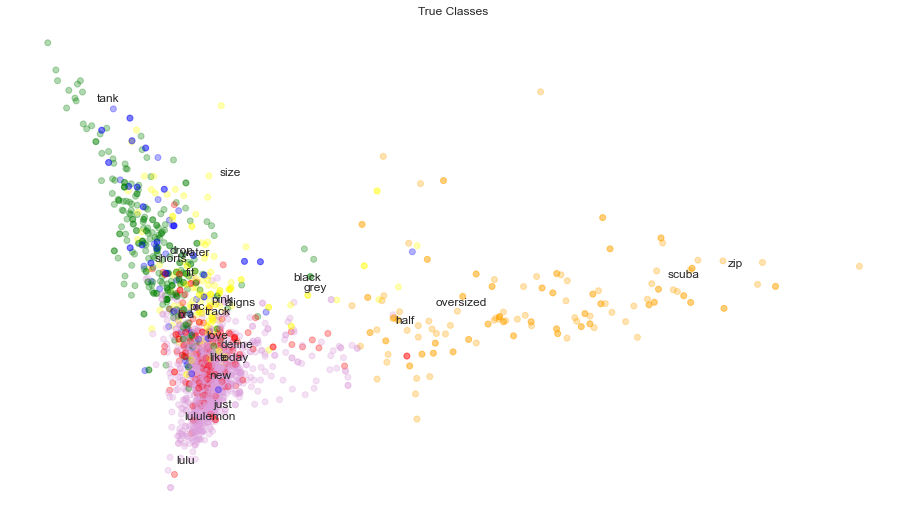

In [65]:
reddit = kMeanClustering(reddit, 6)

Evaluations
Homogeneity: 0.154
Completeness: 1.000
V-measure: 0.266
Adjusted Rand Score: 0.000

Top terms per cluster:
Cluster 0:
 listing
 poshmark
 closet
 added
 check
 just
 shopmycloset
 poshmarkapp
 tank
 size


Cluster 1:
 leggings
 think
 love
 pair
 align
 really
 bought
 pockets
 rt
 wearing


Cluster 2:
 wage
 minimum
 sinema
 bag
 rt
 15
 raising
 voted
 senatorsinema
 carrying


Cluster 3:
 srfn_fitness
 paynter_craig
 cool
 1scrummymummy
 shoes
 abs
 awesome
 cars
 love
 nice


Cluster 4:
 rt
 like
 just
 pants
 know
 good
 new
 don
 thank
 love


Cluster 5:
 bag
 carrying
 rt
 senatorsinema
 sinema
 vote
 kyrstensinema
 kyrsten
 voting
 people




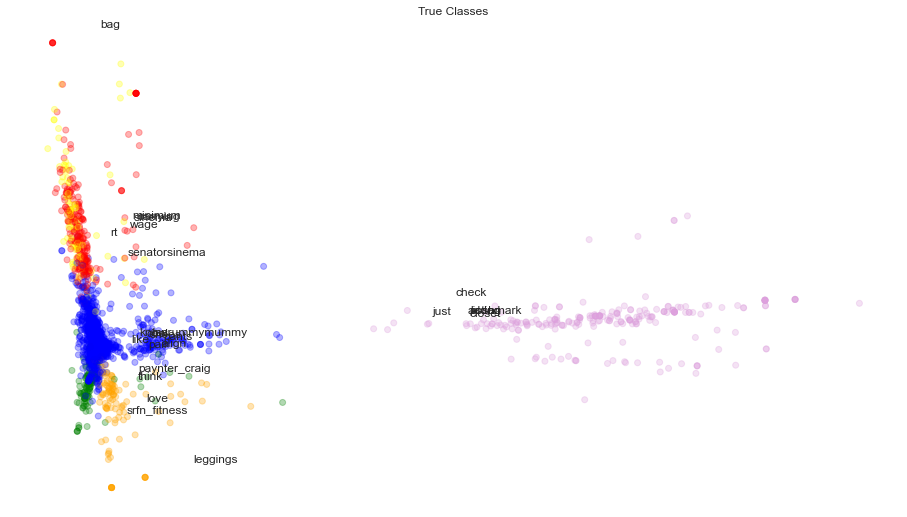

In [66]:
twitter = kMeanClustering(twitter, 6)

Evaluations
Homogeneity: 0.172
Completeness: 1.000
V-measure: 0.294
Adjusted Rand Score: 0.000

Top terms per cluster:
Cluster 0:
 women
 day
 international
 happy
 internationalwomensday
 strong
 woman
 world
 today
 womensupportingwomen


Cluster 1:
 thrift
 thriftedfashion
 sold
 shipping
 lululemonforsale
 drop
 thrifting
 brandymelville
 size
 clothesforsale


Cluster 2:
 strengthworkout
 armworkout
 abworkout
 fitnessreview
 hiitworkout
 sydneysquad
 sydneycummings
 cardioworkout
 workoutathome
 legworkout


Cluster 3:
 size
 lulu
 leggings
 shipping
 sold
 vintage
 condition
 dm
 bin
 free


Cluster 4:
 yoga
 love
 time
 just
 new
 run
 day
 like
 today
 week


Cluster 5:
 workout
 fitness
 gym
 fitnessmotivation
 fit
 leg
 squats
 day
 fitnessjourney
 gymshark




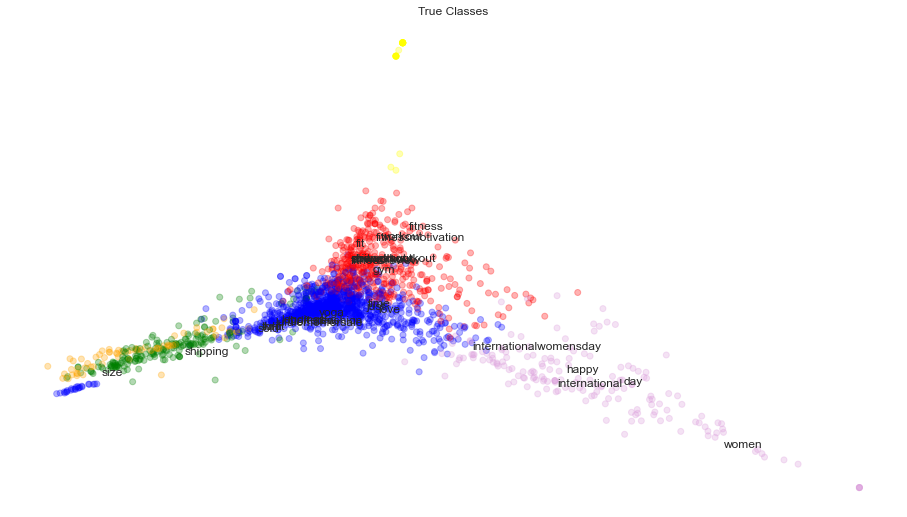

In [67]:
ins = kMeanClustering(ins, 6)

Evaluations
Homogeneity: 0.275
Completeness: 1.000
V-measure: 0.431
Adjusted Rand Score: 0.000

Top terms per cluster:
Cluster 0:
 mat
 bag
 definitely
 does
 ahead
 color
 um
 pocket
 sure
 size


Cluster 1:
 cute
 wear
 um
 bra
 black
 yeah
 super
 size
 shorts
 color


Cluster 2:
 yoga
 pants
 company
 people
 classes
 women
 store
 class
 wear
 spray


Cluster 3:
 stock
 company
 percent
 sales
 year
 market
 chip
 news
 ceo
 women


Cluster 4:
 exhale
 breath
 left
 inhale
 hands
 breathing
 deep
 practice
 hips
 knees


Cluster 5:
 music
 start
 body
 running
 seconds
 run
 feeling
 race
 leg
 doing


Cluster 6:
 yeah
 people
 oh
 um
 okay
 say
 work
 store
 day
 team




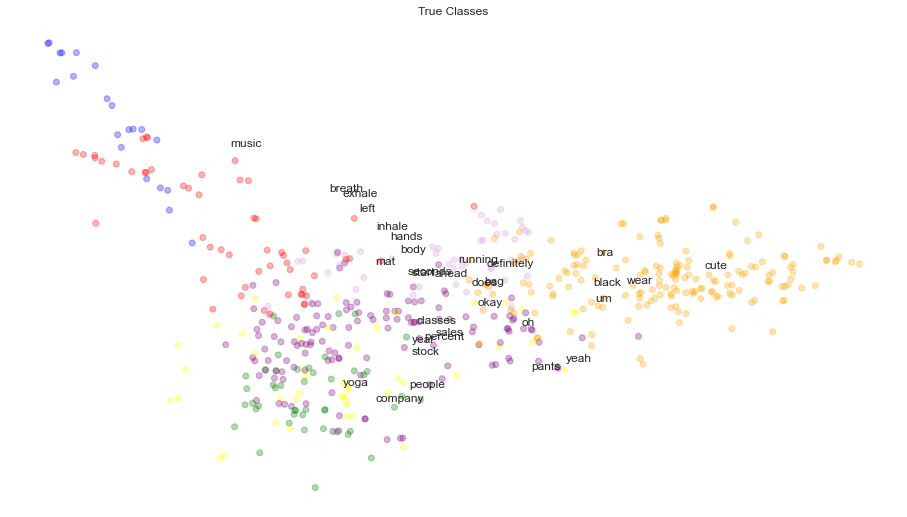

In [68]:
youtube = kMeanClustering(youtube, 7)

#### Hierarchical Cluster

In [69]:
def getLinkageMatrix(TFVects):
    CoocMat = TFVects * TFVects.T
    CoocMat.setdiag(0)
    matrix = scipy.cluster.hierarchy.ward(CoocMat[:50, :50].toarray())
    return matrix

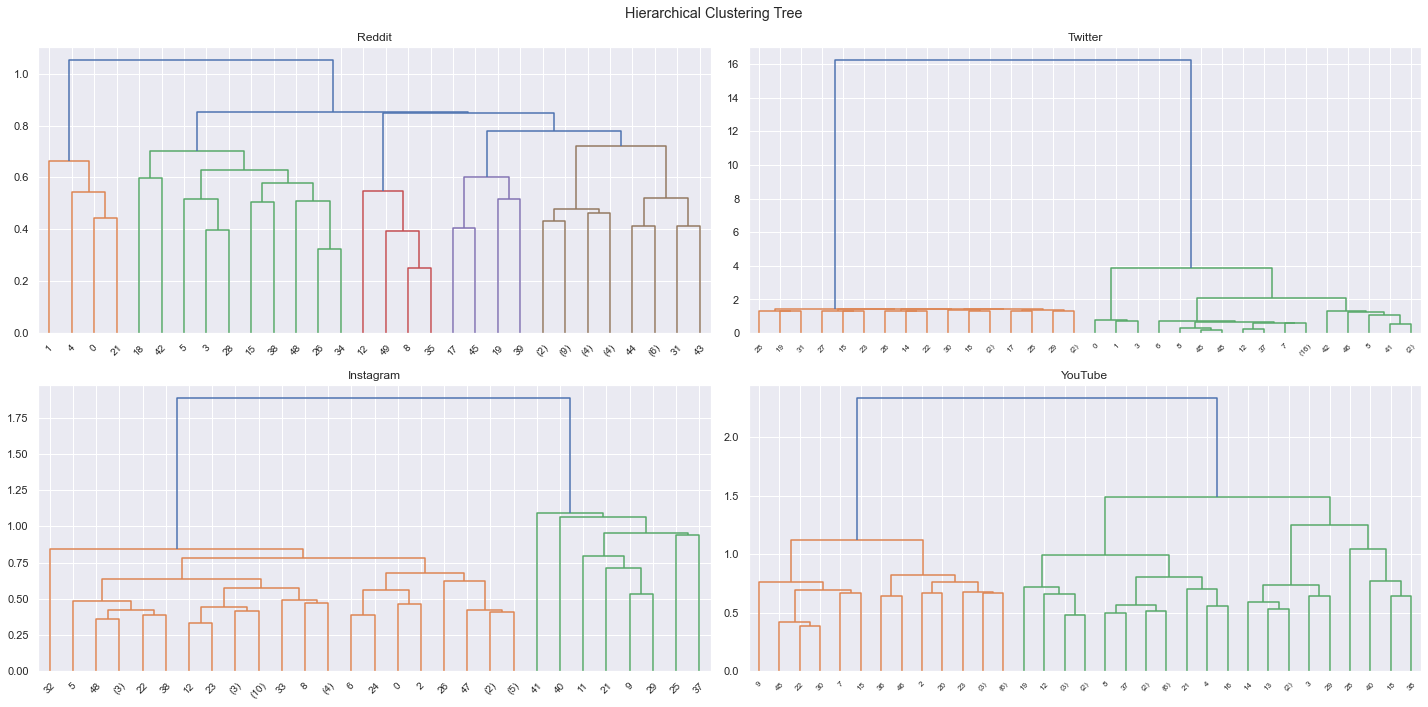

In [70]:
fig, axs = plt.subplots(2, 2, figsize=(20, 10))
fig.suptitle("Hierarchical Clustering Tree")

rdt_matrix = getLinkageMatrix(rdtTFVects)
scipy.cluster.hierarchy.dendrogram(rdt_matrix, p=6, truncate_mode='level', get_leaves=True, ax=axs[0, 0])
axs[0, 0].set_title("Reddit")
twt_matrix = getLinkageMatrix(twtTFVects)
scipy.cluster.hierarchy.dendrogram(twt_matrix, p=6, truncate_mode='level', get_leaves=True, ax=axs[0, 1])
axs[0, 1].set_title("Twitter")

ins_matrix = getLinkageMatrix(insTFVects)
scipy.cluster.hierarchy.dendrogram(ins_matrix, p=6, truncate_mode='level', get_leaves=True, ax=axs[1, 0])
axs[1, 0].set_title("Instagram")
ytb_matrix = getLinkageMatrix(ytbTFVects)
scipy.cluster.hierarchy.dendrogram(ytb_matrix, p=5, truncate_mode='level', get_leaves=True, ax=axs[1, 1])
axs[1, 1].set_title("YouTube")

fig.tight_layout()
plt.show()

In [71]:
def calculateWaldClustering(TFVects, title, n, df):
    CoocMat = TFVects * TFVects.T
    linkage_matrix_full = scipy.cluster.hierarchy.ward(CoocMat.toarray())
    hierarchicalClusters_full = scipy.cluster.hierarchy.fcluster(linkage_matrix_full, n, 'maxclust')
    print("Silhouetter score for " + title + " is " + 
          str(sklearn.metrics.silhouette_score(CoocMat, hierarchicalClusters_full)))
    df['wald_predictions'] = hierarchicalClusters_full
    return df

In [72]:
reddit = calculateWaldClustering(rdtTFVects, "Reddit", 6, reddit)
twitter = calculateWaldClustering(twtTFVects, "Twitter", 6, twitter)
ins = calculateWaldClustering(insTFVects, "Instagram", 6, ins)
youtube = calculateWaldClustering(ytbTFVects, "YouTube", 6, youtube)

Silhouetter score for Reddit is 0.0560934590331155
Silhouetter score for Twitter is 0.17071191784694048
Silhouetter score for Instagram is 0.08521307009483556
Silhouetter score for YouTube is 0.12607526853089465


#### Genism

In [73]:
def dropMissing(wordLst, vocab):
    return [w for w in wordLst if w in vocab]

reddit['reduced_tokens'] = reddit['normalized_tokens'].apply(lambda x: dropMissing(x, rdtTFVectorizer.vocabulary_.keys()))
twitter['reduced_tokens'] = twitter['normalized_tokens'].apply(lambda x: dropMissing(x, twtTFVectorizer.vocabulary_.keys()))
ins['reduced_tokens'] = ins['normalized_tokens'].apply(lambda x: dropMissing(x, insTFVectorizer.vocabulary_.keys()))
youtube['reduced_tokens'] = youtube['normalized_tokens'].apply(lambda x: dropMissing(x, ytbTFVectorizer.vocabulary_.keys()))

In [74]:
def conductLDAModel(df, title):
    dictionary = gensim.corpora.Dictionary(df['reduced_tokens'])
    corpus = [dictionary.doc2bow(text) for text in df['reduced_tokens']]
    gensim.corpora.MmCorpus.serialize(title, corpus)
    mmcorpus = gensim.corpora.MmCorpus(title)
    lda = gensim.models.ldamodel.LdaModel(corpus=mmcorpus, id2word=dictionary, num_topics=10, alpha='auto', eta='auto')
    return dictionary, lda

In [75]:
rdt_dict, rdt_lda = conductLDAModel(reddit, "Reddit")
twt_dict, twt_lda = conductLDAModel(twitter, "Twitter")
ins_dict, ins_lda = conductLDAModel(ins, "Instagram")
ytb_dict, ytb_lda = conductLDAModel(youtube, "YouTube")

#### Reddit

In [76]:
rdt_ldaDF = pd.DataFrame({'upvotes' : reddit['upvotes'], 
                         'topics' : [rdt_lda[rdt_dict.doc2bow(l)] for l in reddit['reduced_tokens']]})
topicsProbDict = {i : [0] * len(rdt_ldaDF) for i in range(rdt_lda.num_topics)}

for index, topicTuples in enumerate(rdt_ldaDF['topics']):
    for topicNum, prob in topicTuples:
        topicsProbDict[topicNum][index] = prob

for topicNum in range(rdt_lda.num_topics):
    rdt_ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]

rdt_ldaDF.head()

,upvotes,topics,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,1,"[(0, 0.26190752), (2, 0.41420063), (4, 0.29844...",0.261908,0.000000,0.414201,0.000000,0.298441,0.000000,0.000000,0.000000,0.000000,0.000000
1,1,"[(2, 0.15705422), (3, 0.092981875), (9, 0.6937...",0.000000,0.000000,0.157054,0.092982,0.000000,0.000000,0.000000,0.000000,0.000000,0.693760
2,1,"[(4, 0.20955442), (5, 0.40047827), (8, 0.35004...",0.000000,0.000000,0.000000,0.000000,0.209554,0.400478,0.000000,0.000000,0.350048,0.000000
3,6,"[(0, 0.028871844), (1, 0.027658872), (2, 0.744...",0.028872,0.027659,0.744676,0.025369,0.027423,0.026797,0.026933,0.029611,0.030113,0.032549
4,2,"[(1, 0.11763585), (6, 0.19441336), (9, 0.65357...",0.000000,0.117636,0.000000,0.000000,0.000000,0.000000,0.194413,0.000000,0.000000,0.653576


In [77]:
rdt_ldaDF.sort_values(by=['upvotes'], ascending=False, inplace=True)
rdt_ldaDFV = rdt_ldaDF[:10][['topic_%d' %x for x in range(10)]]
rdt_ldaDFVisN = rdt_ldaDF[:10][['upvotes']]
rdt_ldaDFVis = rdt_ldaDFV.values
rdt_ldaDFVisNames = rdt_ldaDFVisN.values

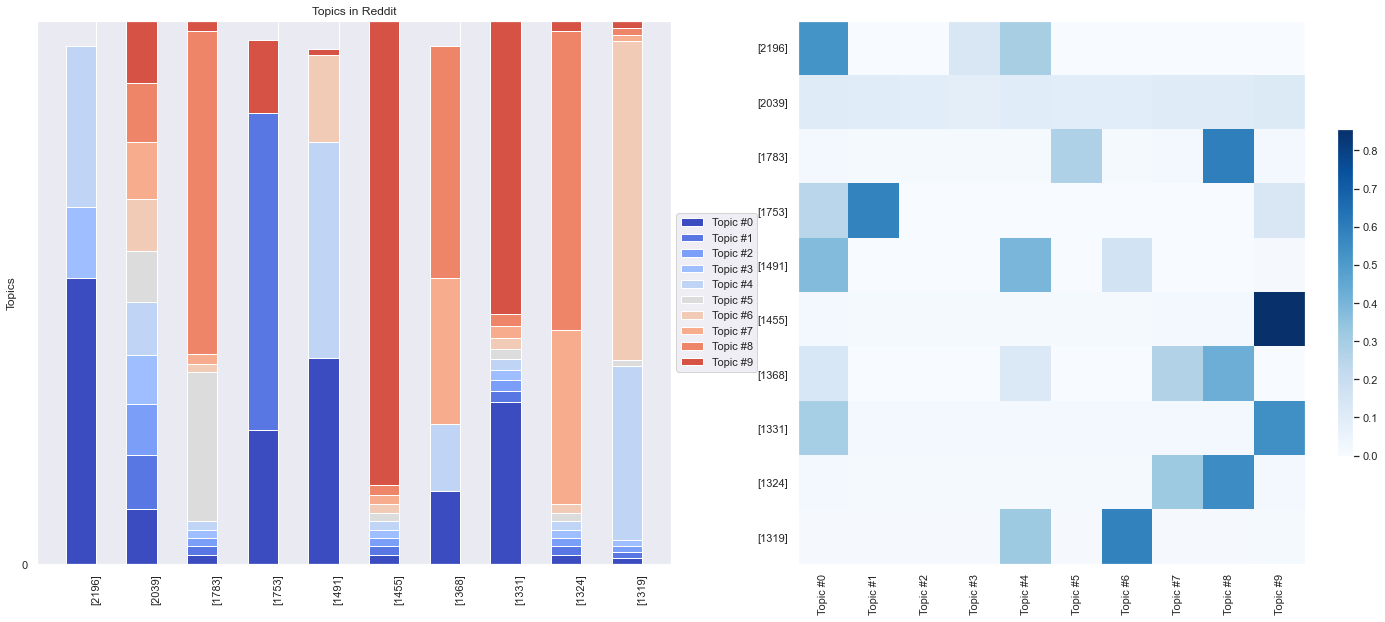

In [78]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))

# Visualize as a stacked bar chart
N = 10
ind = np.arange(N)
K = rdt_lda.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = ax1.bar(ind, rdt_ldaDFVis[:, k], width, color=color)
    else:
        p = ax1.bar(ind, rdt_ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += rdt_ldaDFVis[:, k]
    plots.append(p)
    
ax1.set_ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
ax1.set_ylabel('Topics')

ax1.set_title('Topics in ' + "Reddit")
ax1.set_xticks(ind+width/2)
ax1.set_xticklabels(rdt_ldaDFVisNames, rotation='vertical')

ax1.set_yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
ax1.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))
ax1.figure.show()

ax2.pcolor(rdt_ldaDFVis, norm=None, cmap='Blues')
ax2.set_yticks(np.arange(rdt_ldaDFVis.shape[0])+0.5)
ax2.set_yticklabels(rdt_ldaDFVisNames);
ax2.set_xticks(np.arange(rdt_ldaDFVis.shape[1])+0.5)
ax2.set_xticklabels(topic_labels, rotation=90);
ax2.invert_yaxis()
fig.colorbar(ax2.pcolormesh(rdt_ldaDFVis, norm=None, cmap='Blues'), ax=ax2, shrink=0.6)

plt.show()

In [79]:
topicsDict = {}
for topicNum in range(rdt_lda.num_topics):
    topicWords = [w for w, p in rdt_lda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF = pd.DataFrame(topicsDict)
wordRanksDF

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9
0,store,bra,wunder,short,wmtm,blue,water,lulu,embrace,zip
1,lulu,crop,train,need,lululemon,love,drop,fit,quilted,scuba
2,align,blue,tee,color,amazing,scuba,track,green,like,align
3,fabric,love,shorts,align,thought,got,zip,love,grey,oversized
4,shorts,black,align,fit,want,bra,color,grey,bags,today
5,like,tank,lavender,lol,pink,aligns,aligns,time,camo,fit
6,try,align,leggings,day,know,ink,hr,black,city,day
7,time,train,dew,love,chat,group,bra,wunder,high,tank
8,love,aligns,got,sizes,new,interview,shorts,sunday,rise,half
9,pockets,white,cropped,tags,post,regatta,align,align,align,love


In [80]:
rdt_ldaDFV = rdt_ldaDF[-10:][['topic_%d' %x for x in range(10)]]
rdt_ldaDFVisN = rdt_ldaDF[-10:][['upvotes']]
rdt_ldaDFVis = rdt_ldaDFV.values
rdt_ldaDFVisNames = rdt_ldaDFVisN.values

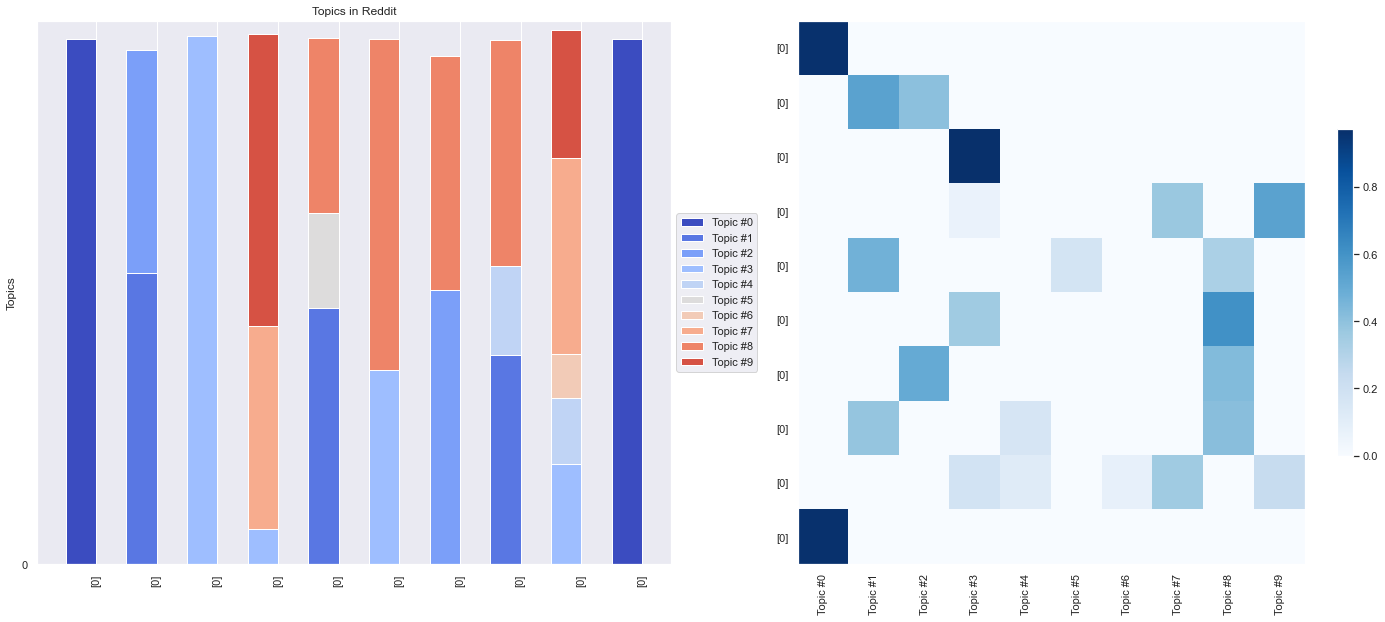

In [81]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))

# Visualize as a stacked bar chart
N = 10
ind = np.arange(N)
K = rdt_lda.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = ax1.bar(ind, rdt_ldaDFVis[:, k], width, color=color)
    else:
        p = ax1.bar(ind, rdt_ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += rdt_ldaDFVis[:, k]
    plots.append(p)
    
ax1.set_ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
ax1.set_ylabel('Topics')

ax1.set_title('Topics in ' + "Reddit")
ax1.set_xticks(ind+width/2)
ax1.set_xticklabels(rdt_ldaDFVisNames, rotation='vertical')

ax1.set_yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
ax1.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))
ax1.figure.show()

ax2.pcolor(rdt_ldaDFVis, norm=None, cmap='Blues')
ax2.set_yticks(np.arange(rdt_ldaDFVis.shape[0])+0.5)
ax2.set_yticklabels(rdt_ldaDFVisNames);
ax2.set_xticks(np.arange(rdt_ldaDFVis.shape[1])+0.5)
ax2.set_xticklabels(topic_labels, rotation=90);
ax2.invert_yaxis()
fig.colorbar(ax2.pcolormesh(rdt_ldaDFVis, norm=None, cmap='Blues'), ax=ax2, shrink=0.6)

plt.show()

#### Twitter

In [82]:
twt_ldaDF = pd.DataFrame({'favorite_cnt' : twitter['favorite_cnt'],
                         'topics' : [twt_lda[twt_dict.doc2bow(l)] for l in twitter['reduced_tokens']]})
topicsProbDict = {i : [0] * len(twt_ldaDF) for i in range(twt_lda.num_topics)}

for index, topicTuples in enumerate(twt_ldaDF['topics']):
    for topicNum, prob in topicTuples:
        topicsProbDict[topicNum][index] = prob

for topicNum in range(twt_lda.num_topics):
    twt_ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]

twt_ldaDF.head()

,favorite_cnt,topics,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,0,"[(5, 0.010498925), (8, 0.9120028)]",0.000000,0.000000,0.000000,0.000000,0.000000,0.010499,0.000000,0.000000,0.912003,0.000000
2,0,"[(0, 0.012743974), (1, 0.012491724), (2, 0.012...",0.012744,0.012492,0.012547,0.012345,0.012571,0.013550,0.012388,0.012182,0.886427,0.012754
3,0,"[(0, 0.79601234), (1, 0.022159394), (2, 0.0222...",0.796012,0.022159,0.022259,0.021901,0.022303,0.024039,0.021977,0.021612,0.025111,0.022627
4,0,"[(1, 0.707201), (5, 0.010497796), (8, 0.214486...",0.000000,0.707201,0.000000,0.000000,0.000000,0.010498,0.000000,0.000000,0.214487,0.000000
5,0,"[(0, 0.014918982), (1, 0.014621238), (2, 0.014...",0.014919,0.014621,0.014687,0.014451,0.014716,0.168049,0.536259,0.014261,0.016566,0.191471


In [83]:
twt_ldaDF.sort_values(by=['favorite_cnt'], ascending=False, inplace=True)
twt_ldaDFV = twt_ldaDF[:10][['topic_%d' %x for x in range(10)]]
twt_ldaDFVisN = twt_ldaDF[:10][['favorite_cnt']]
twt_ldaDFVis = twt_ldaDFV.values
twt_ldaDFVisNames = twt_ldaDFVisN.values

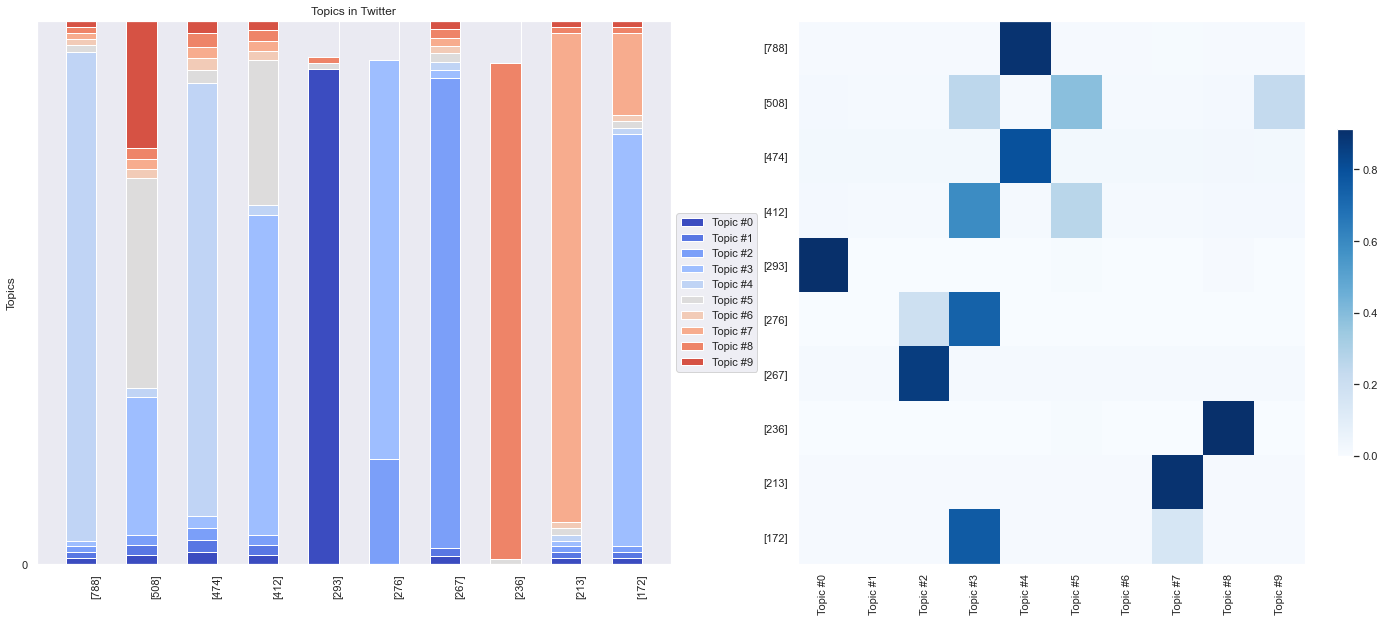

In [84]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))

# Visualize as a stacked bar chart
N = 10
ind = np.arange(N)
K = twt_lda.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = ax1.bar(ind, twt_ldaDFVis[:, k], width, color=color)
    else:
        p = ax1.bar(ind, twt_ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += twt_ldaDFVis[:, k]
    plots.append(p)
    
ax1.set_ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
ax1.set_ylabel('Topics')

ax1.set_title('Topics in ' + "Twitter")
ax1.set_xticks(ind+width/2)
ax1.set_xticklabels(twt_ldaDFVisNames, rotation='vertical')

ax1.set_yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
ax1.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))
ax1.figure.show()

ax2.pcolor(twt_ldaDFVis, norm=None, cmap='Blues')
ax2.set_yticks(np.arange(twt_ldaDFVis.shape[0])+0.5)
ax2.set_yticklabels(twt_ldaDFVisNames);
ax2.set_xticks(np.arange(twt_ldaDFVis.shape[1])+0.5)
ax2.set_xticklabels(topic_labels, rotation=90);
ax2.invert_yaxis()
fig.colorbar(ax2.pcolormesh(twt_ldaDFVis, norm=None, cmap='Blues'), ax=ax2, shrink=0.6)

plt.show()

In [85]:
topicsDict = {}
for topicNum in range(twt_lda.num_topics):
    topicWords = [w for w, p in twt_lda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF = pd.DataFrame(topicsDict)
wordRanksDF

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9
0,sinema,closet,think,gift,sinema,pants,like,wage,check,good
1,people,added,look,yoga,today,know,ordered,minimum,closet,buy
2,wage,listing,clothes,card,love,new,love,voted,added,fit
3,like,poshmark,performance,ve,kyrsten,yoga,bra,brought,poshmark,need
4,senator,check,workout,wearing,let,check,want,huge,listing,favourite
5,later,shopmycloset,amp,fitness,krysten,listing,store,section,leggings,feel
6,expensive,bra,new,mat,people,poshmark,need,carrying,blue,like
7,vote,tank,shorts,got,help,added,thought,day,black,soft
8,word,sports,high,man,away,closet,fancy,purse,purple,person
9,poverty,nwt,good,tried,gear,like,shoulder,raising,buy,summer


In [86]:
twt_ldaDFV = twt_ldaDF[-10:][['topic_%d' %x for x in range(10)]]
twt_ldaDFVisN = twt_ldaDF[-10:][['favorite_cnt']]
twt_ldaDFVis = twt_ldaDFV.values
twt_ldaDFVisNames = twt_ldaDFVisN.values

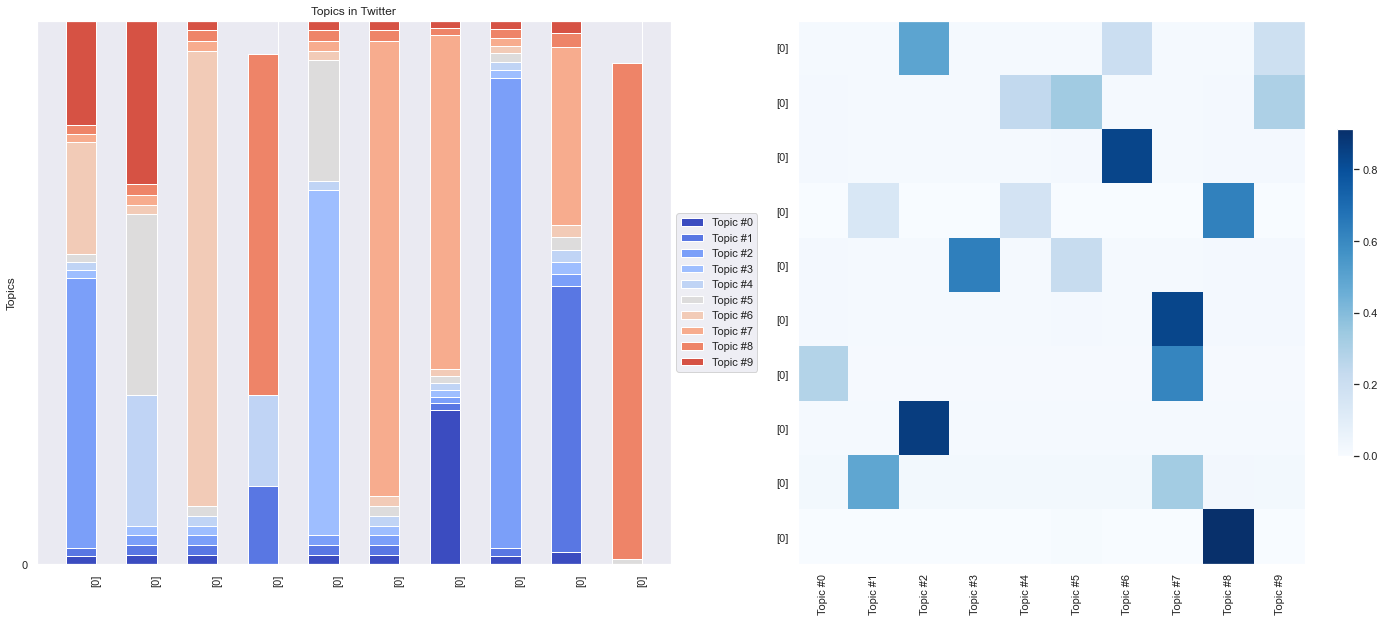

In [87]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))

# Visualize as a stacked bar chart
N = 10
ind = np.arange(N)
K = twt_lda.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = ax1.bar(ind, twt_ldaDFVis[:, k], width, color=color)
    else:
        p = ax1.bar(ind, twt_ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += twt_ldaDFVis[:, k]
    plots.append(p)
    
ax1.set_ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
ax1.set_ylabel('Topics')

ax1.set_title('Topics in ' + "Twitter")
ax1.set_xticks(ind+width/2)
ax1.set_xticklabels(twt_ldaDFVisNames, rotation='vertical')

ax1.set_yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
ax1.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))
ax1.figure.show()

ax2.pcolor(twt_ldaDFVis, norm=None, cmap='Blues')
ax2.set_yticks(np.arange(twt_ldaDFVis.shape[0])+0.5)
ax2.set_yticklabels(twt_ldaDFVisNames);
ax2.set_xticks(np.arange(twt_ldaDFVis.shape[1])+0.5)
ax2.set_xticklabels(topic_labels, rotation=90);
ax2.invert_yaxis()
fig.colorbar(ax2.pcolormesh(twt_ldaDFVis, norm=None, cmap='Blues'), ax=ax2, shrink=0.6)

plt.show()

#### Instagram

In [88]:
ins_ldaDF = pd.DataFrame({'likes' : ins['likes'],
                         'topics' : [ins_lda[ins_dict.doc2bow(l)] for l in ins['reduced_tokens']]})
topicsProbDict = {i : [0] * len(ins_ldaDF) for i in range(ins_lda.num_topics)}

for index, topicTuples in enumerate(ins_ldaDF['topics']):
    for topicNum, prob in topicTuples:
        topicsProbDict[topicNum][index] = prob

for topicNum in range(ins_lda.num_topics):
    ins_ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]

ins_ldaDF.head()

,likes,topics,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,1221,"[(0, 0.15212546), (3, 0.37636867), (6, 0.44821...",0.152125,0.000000,0.000000,0.376369,0.0,0.000000,0.448214,0.000000,0.000000,0.000000
1,1450,"[(6, 0.50809443), (8, 0.42425427)]",0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.508094,0.000000,0.424254,0.000000
2,122,"[(6, 0.9369136)]",0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.936914,0.000000,0.000000,0.000000
3,29781,"[(0, 0.0103340065), (1, 0.010055087), (2, 0.01...",0.010334,0.010055,0.011032,0.011133,0.0,0.011638,0.011668,0.010524,0.010371,0.903389
4,186,"[(2, 0.4001418), (8, 0.50477266), (9, 0.069271...",0.000000,0.000000,0.400142,0.000000,0.0,0.000000,0.000000,0.000000,0.504773,0.069272


In [89]:
ins_ldaDF = ins_ldaDF[ins_ldaDF['likes'].astype(str).str.isdigit()]

In [90]:
ins_ldaDF.sort_values(by=['likes'], ascending=False, inplace=True)
ins_ldaDFV = ins_ldaDF[:10][['topic_%d' %x for x in range(10)]]
ins_ldaDFVisN = ins_ldaDF[:10][['likes']]
ins_ldaDFVis = ins_ldaDFV.values
ins_ldaDFVisNames = ins_ldaDFVisN.values

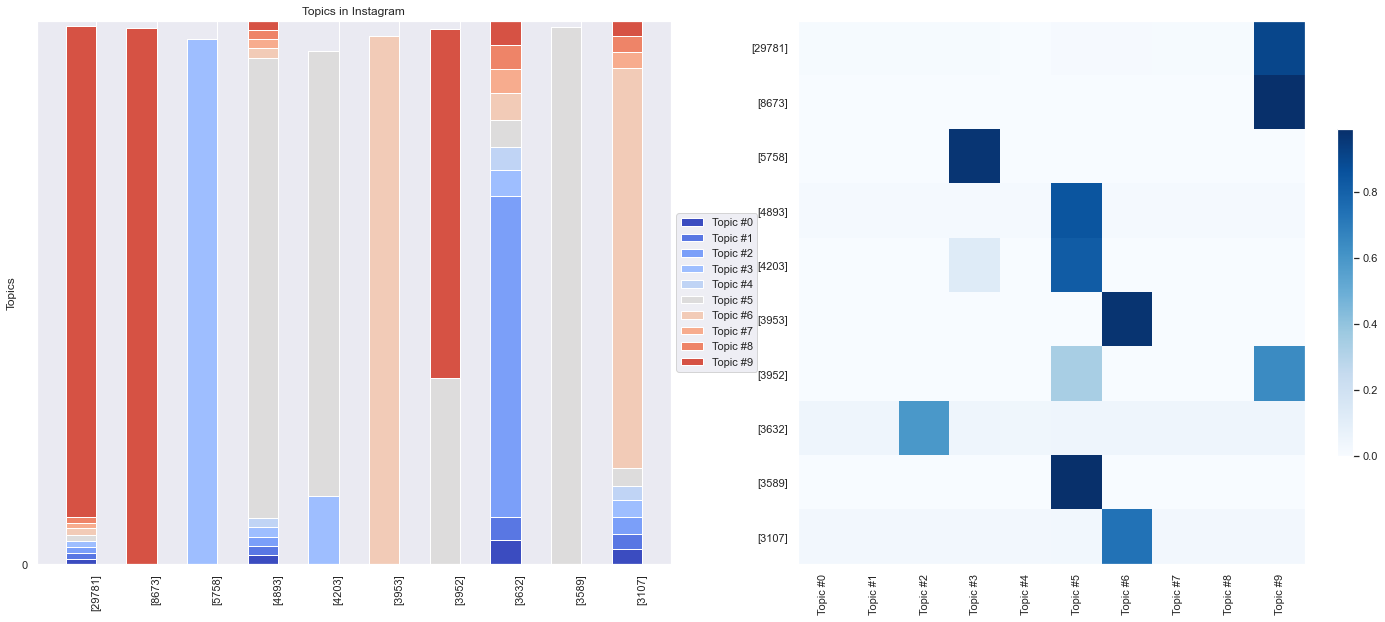

In [91]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))

# Visualize as a stacked bar chart
N = 10
ind = np.arange(N)
K = ins_lda.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = ax1.bar(ind, ins_ldaDFVis[:, k], width, color=color)
    else:
        p = ax1.bar(ind, ins_ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += ins_ldaDFVis[:, k]
    plots.append(p)
    
ax1.set_ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
ax1.set_ylabel('Topics')

ax1.set_title('Topics in ' + "Instagram")
ax1.set_xticks(ind+width/2)
ax1.set_xticklabels(ins_ldaDFVisNames, rotation='vertical')

ax1.set_yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
ax1.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))
ax1.figure.show()

ax2.pcolor(ins_ldaDFVis, norm=None, cmap='Blues')
ax2.set_yticks(np.arange(ins_ldaDFVis.shape[0])+0.5)
ax2.set_yticklabels(ins_ldaDFVisNames);
ax2.set_xticks(np.arange(ins_ldaDFVis.shape[1])+0.5)
ax2.set_xticklabels(topic_labels, rotation=90);
ax2.invert_yaxis()
fig.colorbar(ax2.pcolormesh(ins_ldaDFVis, norm=None, cmap='Blues'), ax=ax2, shrink=0.6)

plt.show()

In [92]:
topicsDict = {}
for topicNum in range(ins_lda.num_topics):
    topicWords = [w for w, p in ins_lda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF = pd.DataFrame(topicsDict)
wordRanksDF

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9
0,fitness,new,day,fitness,leggings,workout,women,gym,yoga,workout
1,canada,thrift,women,life,day,day,day,workout,week,today
2,time,free,time,women,like,women,workout,fitness,day,day
3,look,shipping,nike,happy,squats,love,fitness,day,today,good
4,canadian,yoga,workout,nike,good,fitness,happy,fit,fitness,week
5,like,day,today,love,leg,time,today,new,run,pull
6,week,lulu,like,workout,happy,want,yoga,run,love,body
7,small,sold,fitness,today,workout,leg,international,body,time,fitness
8,workout,thriftedfashion,work,fit,new,happy,week,gymshark,know,4x10
9,let,thrifting,love,fitnessmotivation,feel,body,monday,fitnessmotivation,need,happy


In [93]:
ins_ldaDFV = ins_ldaDF[-10:][['topic_%d' %x for x in range(10)]]
ins_ldaDFVisN = ins_ldaDF[-10:][['likes']]
ins_ldaDFVis = ins_ldaDFV.values
ins_ldaDFVisNames = ins_ldaDFVisN.values

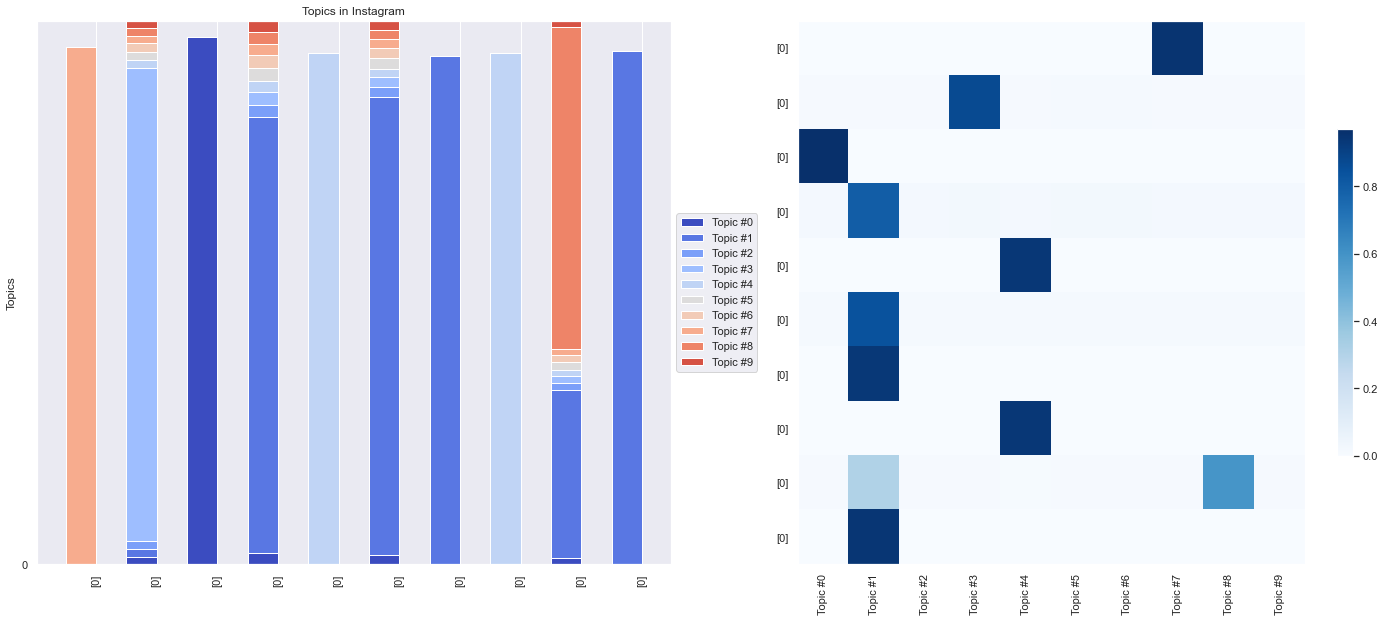

In [94]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))

# Visualize as a stacked bar chart
N = 10
ind = np.arange(N)
K = ins_lda.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = ax1.bar(ind, ins_ldaDFVis[:, k], width, color=color)
    else:
        p = ax1.bar(ind, ins_ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += ins_ldaDFVis[:, k]
    plots.append(p)
    
ax1.set_ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
ax1.set_ylabel('Topics')

ax1.set_title('Topics in ' + "Instagram")
ax1.set_xticks(ind+width/2)
ax1.set_xticklabels(ins_ldaDFVisNames, rotation='vertical')

ax1.set_yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
ax1.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))
ax1.figure.show()

ax2.pcolor(ins_ldaDFVis, norm=None, cmap='Blues')
ax2.set_yticks(np.arange(ins_ldaDFVis.shape[0])+0.5)
ax2.set_yticklabels(ins_ldaDFVisNames);
ax2.set_xticks(np.arange(ins_ldaDFVis.shape[1])+0.5)
ax2.set_xticklabels(topic_labels, rotation=90);
ax2.invert_yaxis()
fig.colorbar(ax2.pcolormesh(ins_ldaDFVis, norm=None, cmap='Blues'), ax=ax2, shrink=0.6)

plt.show()

#### YouTube

In [95]:
ytb_ldaDF = pd.DataFrame({'likeCount' : youtube['likeCount'],
                         'topics' : [ytb_lda[ytb_dict.doc2bow(l)] for l in youtube['reduced_tokens']]})
topicsProbDict = {i : [0] * len(ytb_ldaDF) for i in range(ytb_lda.num_topics)}

for index, topicTuples in enumerate(ytb_ldaDF['topics']):
    for topicNum, prob in topicTuples:
        topicsProbDict[topicNum][index] = prob

for topicNum in range(ytb_lda.num_topics):
    ytb_ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]

ytb_ldaDF.head()

,likeCount,topics,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,17465,"[(1, 0.24197018), (2, 0.02730985), (4, 0.70835...",0.0,0.241970,0.02731,0.000000,0.708358,0.000000,0.000000,0.000000,0.013653,0.000000
1,29,"[(5, 0.48985392), (8, 0.03725893), (9, 0.46599...",0.0,0.000000,0.00000,0.000000,0.000000,0.489854,0.000000,0.000000,0.037259,0.465999
2,86,"[(3, 0.3619522), (5, 0.10627301), (6, 0.095557...",0.0,0.000000,0.00000,0.361952,0.000000,0.106273,0.095557,0.183149,0.000000,0.246591
3,276,"[(1, 0.8575731), (4, 0.14117363)]",0.0,0.857573,0.00000,0.000000,0.141174,0.000000,0.000000,0.000000,0.000000,0.000000
4,91,"[(1, 0.9516727), (9, 0.036368553)]",0.0,0.951673,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.036369


In [107]:
ytb_ldaDF = ytb_ldaDF[ytb_ldaDF.likeCount.str.isnumeric()]
ytb_ldaDF["likeCount"] = ytb_ldaDF["likeCount"].astype(str).astype(int)

In [108]:
ytb_ldaDF.sort_values(by=['likeCount'], ascending=False, inplace=True)
ytb_ldaDFV = ytb_ldaDF[:10][['topic_%d' %x for x in range(10)]]
ytb_ldaDFVisN = ytb_ldaDF[:10][['likeCount']]
ytb_ldaDFVis = ytb_ldaDFV.values
ytb_ldaDFVisNames = ytb_ldaDFVisN.values

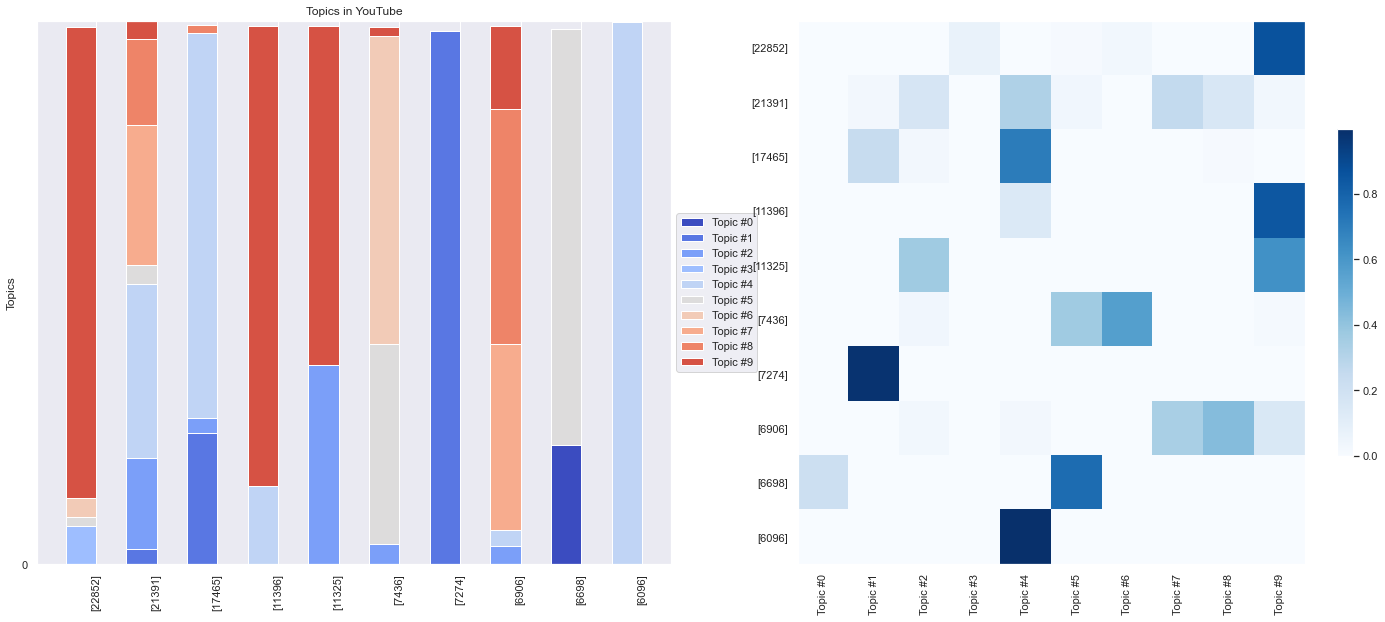

In [109]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))

# Visualize as a stacked bar chart
N = 10
ind = np.arange(N)
K = ytb_lda.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = ax1.bar(ind, ytb_ldaDFVis[:, k], width, color=color)
    else:
        p = ax1.bar(ind, ytb_ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += ytb_ldaDFVis[:, k]
    plots.append(p)
    
ax1.set_ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
ax1.set_ylabel('Topics')

ax1.set_title('Topics in ' + "YouTube")
ax1.set_xticks(ind+width/2)
ax1.set_xticklabels(ytb_ldaDFVisNames, rotation='vertical')

ax1.set_yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
ax1.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))
ax1.figure.show()

ax2.pcolor(ytb_ldaDFVis, norm=None, cmap='Blues')
ax2.set_yticks(np.arange(ytb_ldaDFVis.shape[0])+0.5)
ax2.set_yticklabels(ytb_ldaDFVisNames);
ax2.set_xticks(np.arange(ytb_ldaDFVis.shape[1])+0.5)
ax2.set_xticklabels(topic_labels, rotation=90);
ax2.invert_yaxis()
fig.colorbar(ax2.pcolormesh(ytb_ldaDFVis, norm=None, cmap='Blues'), ax=ax2, shrink=0.6)

plt.show()

In [110]:
topicsDict = {}
for topicNum in range(ytb_lda.num_topics):
    topicWords = [w for w, p in ytb_lda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF = pd.DataFrame(topicsDict)
wordRanksDF

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9
0,yeah,yeah,okay,yeah,pants,um,yeah,yeah,stuff,yeah
1,people,um,wear,um,wear,new,um,cute,wear,wear
2,day,people,black,nice,people,things,wear,um,cute,pants
3,left,things,stuff,definitely,things,pretty,nice,video,yeah,super
4,exhale,nice,people,stuff,yeah,nice,pants,nice,pants,black
5,nice,cute,yoga,pants,yoga,color,come,things,color,great
6,cute,wear,um,video,nice,people,cute,wear,um,cute
7,need,super,cute,oh,cute,cute,super,people,black,color
8,come,color,pretty,yoga,color,video,day,yoga,nice,bra
9,okay,oh,oh,great,try,pants,long,sure,yoga,video


In [111]:
ytb_ldaDFV = ytb_ldaDF[-10:][['topic_%d' %x for x in range(10)]]
ytb_ldaDFVisN = ytb_ldaDF[-10:][['likeCount']]
ytb_ldaDFVis = ytb_ldaDFV.values
ytb_ldaDFVisNames = ytb_ldaDFVisN.values

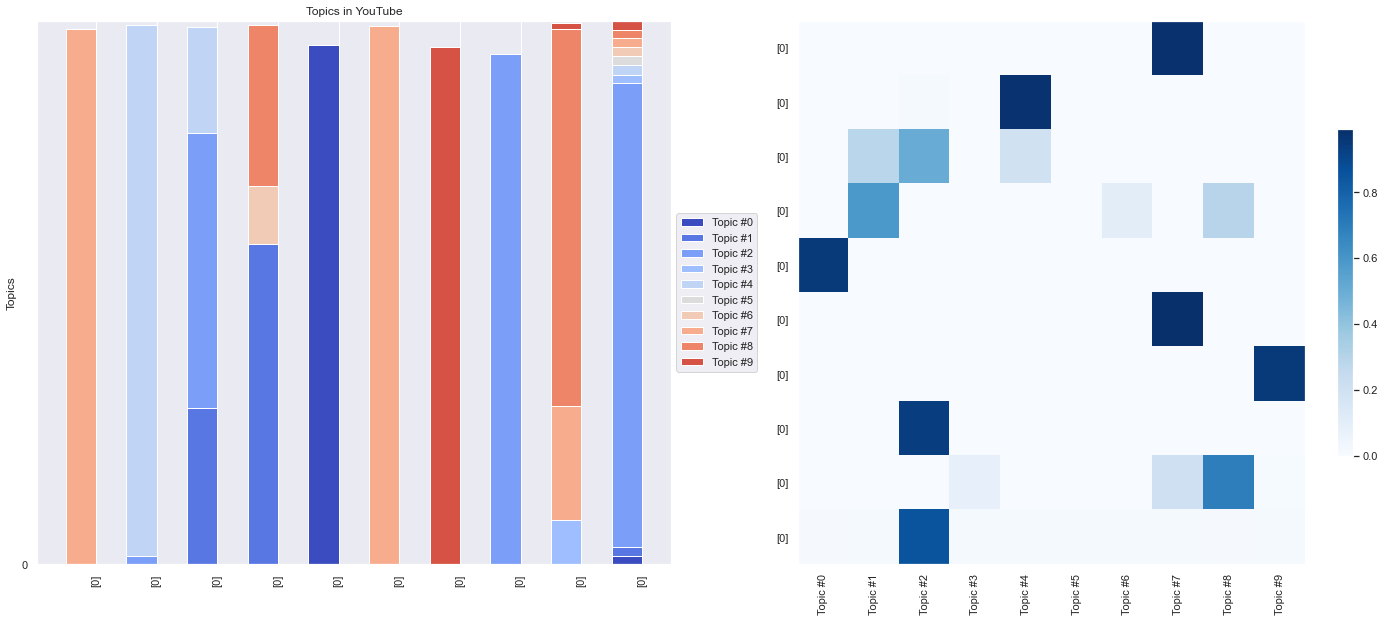

In [112]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))

# Visualize as a stacked bar chart
N = 10
ind = np.arange(N)
K = ytb_lda.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = ax1.bar(ind, ytb_ldaDFVis[:, k], width, color=color)
    else:
        p = ax1.bar(ind, ytb_ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += ytb_ldaDFVis[:, k]
    plots.append(p)
    
ax1.set_ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
ax1.set_ylabel('Topics')

ax1.set_title('Topics in ' + "YouTube")
ax1.set_xticks(ind+width/2)
ax1.set_xticklabels(ytb_ldaDFVisNames, rotation='vertical')

ax1.set_yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
ax1.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))
ax1.figure.show()

ax2.pcolor(ytb_ldaDFVis, norm=None, cmap='Blues')
ax2.set_yticks(np.arange(ytb_ldaDFVis.shape[0])+0.5)
ax2.set_yticklabels(ytb_ldaDFVisNames);
ax2.set_xticks(np.arange(ytb_ldaDFVis.shape[1])+0.5)
ax2.set_xticklabels(topic_labels, rotation=90);
ax2.invert_yaxis()
fig.colorbar(ax2.pcolormesh(ytb_ldaDFVis, norm=None, cmap='Blues'), ax=ax2, shrink=0.6)

plt.show()

#### NLTK Topic Modeling

In [113]:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": nltk.corpus.wordnet.ADJ,
                "N": nltk.corpus.wordnet.NOUN,
                "V": nltk.corpus.wordnet.VERB,
                "R": nltk.corpus.wordnet.ADV}

    return tag_dict.get(tag, nltk.corpus.wordnet.NOUN)

def get_lemmas(text):
    stop = nltk.corpus.stopwords.words('english') + list(string.punctuation)
    tokens = [i for i in nltk.word_tokenize(text.lower()) if i not in stop]
    lemmas = [nltk.stem.WordNetLemmatizer().lemmatize(t, get_wordnet_pos(t)) for t in tokens]
    return lemmas

def make_bigrams(lemmas, min_count=5):
    bigram = models.Phrases(lemmas, min_count)
    bigram_mod = models.phrases.Phraser(bigram)
    return [bigram_mod[doc] for doc in lemmas]

def make_bag_words(lemmas):
    dictionary = corpora.Dictionary([i for i in lemmas])
    bow_corpus = [dictionary.doc2bow(text) for text in lemmas]
    return dictionary, bow_corpus

In [114]:
def nltkTopicModeling(df_list, title_list, num_topics=3, num_words=20):
    for i in range(len(df_list)):
        print("Topic Modeling for " + title_list[i])
        text = df_list[i].text.apply(get_lemmas)
        dic, bow = make_bag_words(make_bigrams(text))
        model = models.ldamodel.LdaModel(bow, num_topics=num_topics, id2word=dic, passes=20, iterations=400)
        print(model.print_topics(num_words=num_words))
        print("\n")

In [115]:
nltkTopicModeling(df_lst, title_lst)

Topic Modeling for Reddit
[(0, '0.019*"’" + 0.010*"get" + 0.008*"day" + 0.008*"4" + 0.007*"black" + 0.006*"lululemon" + 0.006*"love" + 0.006*"\'s" + 0.005*"post" + 0.005*"today" + 0.005*"take" + 0.005*"\'re" + 0.005*"wear" + 0.004*"one" + 0.004*"new" + 0.004*"\'m" + 0.004*"1/2_zip" + 0.004*"need" + 0.004*"lulu" + 0.004*"make"'), (1, '0.026*"’" + 0.010*"get" + 0.009*"go" + 0.009*"size" + 0.008*"love" + 0.008*"color" + 0.007*"..." + 0.007*"like" + 0.007*"lulu" + 0.007*"wear" + 0.007*"http" + 0.006*"legging" + 0.006*"time" + 0.005*"look" + 0.005*"store" + 0.005*"much" + 0.005*"tank" + 0.005*"one" + 0.005*"wmtm" + 0.005*"”"'), (2, '0.038*"’" + 0.011*"size" + 0.010*"short" + 0.009*"align" + 0.007*"new" + 0.006*"http" + 0.005*"6" + 0.005*"love" + 0.005*"anyone" + 0.005*"fit" + 0.005*"lulu" + 0.005*"zip" + 0.005*"fabric" + 0.005*"pair" + 0.005*"try" + 0.005*"5" + 0.005*"scuba_1/2" + 0.005*"color" + 0.005*"bra" + 0.004*"want"')]


Topic Modeling for Twitter
[(0, '0.057*"lululemon" + 0.033*"che